# Final Project: Parallelization of Deep Learning Models for Retinal Lesion Detection

### Team Members : 
- **Lokeshwaran Venugopal Balamurugan**
- **Lakshman Raaj Senthil Nathan**

#### ----- Import Neccessary Libraries and Initial Setup -----


In [1]:
# Importing essential libraries and setting up the environment for the project.
import os
CUDA_LAUNCH_BLOCKING = 1 # Ensures that CUDA operations are performed synchronously
import pandas as pd
import numpy as np

import random
import shutil

import tensorflow as tf
from tensorflow import keras

# visualizations libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

import shutil
import os
from multiprocessing import Pool
import time

In [2]:
!nvidia-smi

Sat Dec  2 03:11:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-12GB            Off| 00000000:03:00.0 Off |                    0 |
| N/A   37C    P0               29W / 250W|      0MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### ----- Data Overview and Exploration -----



In [3]:
base_dir= "/home/venugopalbalamurug.l/kaggle/www.kaggle.com/datasets/paultimothymooney/kermany2018/OCT2017 /train/"
classes = os.listdir(base_dir)
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [4]:
cnv_sample_data= r"/home/venugopalbalamurug.l/kaggle/www.kaggle.com/datasets/paultimothymooney/kermany2018/OCT2017 /train/CNV"
print("CNV images :\n" ,os.listdir(cnv_sample_data)[:5])

dme_sample_data= r"/home/venugopalbalamurug.l/kaggle/www.kaggle.com/datasets/paultimothymooney/kermany2018/OCT2017 /train/DME"
print("\nDME images :\n" ,os.listdir(dme_sample_data)[:5])

drusen_sample_data= r"/home/venugopalbalamurug.l/kaggle/www.kaggle.com/datasets/paultimothymooney/kermany2018/OCT2017 /train/DRUSEN"
print("\nDRUSEN images :\n" ,os.listdir(drusen_sample_data)[:5])

normal_sample_data= r"/home/venugopalbalamurug.l/kaggle/www.kaggle.com/datasets/paultimothymooney/kermany2018/OCT2017 /train/NORMAL"
print("\npNormal images :\n" ,os.listdir(normal_sample_data)[:5])

CNV images :
 ['CNV-1016042-1.jpeg', 'CNV-1016042-10.jpeg', 'CNV-1016042-100.jpeg', 'CNV-1016042-101.jpeg', 'CNV-1016042-102.jpeg']

DME images :
 ['.ipynb_checkpoints', 'DME-1072015-1.jpeg', 'DME-1072015-2.jpeg', 'DME-1072015-3.jpeg', 'DME-1072015-4.jpeg']

DRUSEN images :
 ['DRUSEN-1001666-1.jpeg', 'DRUSEN-1001666-2.jpeg', 'DRUSEN-1001666-3.jpeg', 'DRUSEN-1001666-4.jpeg', 'DRUSEN-1001666-5.jpeg']

pNormal images :
 ['NORMAL-1001666-1.jpeg', 'NORMAL-1001772-1.jpeg', 'NORMAL-1001772-2.jpeg', 'NORMAL-1001772-3.jpeg', 'NORMAL-1001772-4.jpeg']


In [5]:
print("no. of CNV images :" ,len(os.listdir(cnv_sample_data)))
print("\nno. of DME images :" ,len(os.listdir(dme_sample_data)))
print("\nno. of DRUSEN images :" ,len(os.listdir(drusen_sample_data)))
print("\nno. of Normal images :" ,len(os.listdir(normal_sample_data)))

no. of CNV images : 37205

no. of DME images : 11349

no. of DRUSEN images : 8616

no. of Normal images : 26315


#### ----- Initial Class Distribution before balancing -----


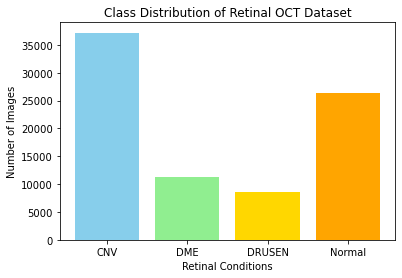

In [6]:
# Count the number of images in each class
cnv_count = len(os.listdir(cnv_sample_data))
dme_count = len(os.listdir(dme_sample_data))
drusen_count = len(os.listdir(drusen_sample_data))
normal_count = len(os.listdir(normal_sample_data))

# Class labels and counts
class_labels = ['CNV', 'DME', 'DRUSEN', 'Normal']
class_counts = [cnv_count, dme_count, drusen_count, normal_count]

# Create a bar plot
plt.bar(class_labels, class_counts, color=['skyblue', 'lightgreen', 'gold', 'orange'])
plt.xlabel('Retinal Conditions')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Retinal OCT Dataset')
plt.show()


The bar chart visualizes the initial class distribution of a retinal OCT dataset, showing the number of images available for each of the four categories: CNV (Choroidal Neovascularization), DME (Diabetic Macular Edema), DRUSEN, and Normal. The visualization highlights the imbalance among the different classes before any data balancing techniques are applied.

### ----- **Parallel** Data Preparation for Training -----


#### Move data from main directory to train directory

In [7]:
target_dir = "/home/venugopalbalamurug.l/Dataset/train/"

In [8]:
# Define the function to copy files from the main directory to the training directory.
def copy_files(args):
    class_name, class_dir, target_dir, target_count = args
    target_class_dir = os.path.join(target_dir, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    random.shuffle(all_files)  # Shuffle the order of files

    current_count = len(os.listdir(target_class_dir))
    files_needed = target_count - current_count

    if current_count >= target_count:
        print(f"Skipping {class_name}, target directory already has {target_count} files.")
        return

    if len(all_files) > files_needed:
        selected_files = set(random.sample(all_files, files_needed))
    else:
        selected_files = set(all_files)

    for file in selected_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(target_class_dir, file))

In [9]:
def run_parallel_copy(n_processes):
    print(f"Running with {n_processes} processes")
    start_time = time.time()

    with Pool(processes=n_processes) as pool:
        pool.map(copy_files, args)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken with {n_processes} processes: {elapsed_time} seconds\n")
    return elapsed_time

In [10]:
def clear_target_directory(target_dir):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir, exist_ok=True)

In [11]:
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']  # Example class names
target_count = 8616

# Prepare the arguments for each class
args = [(class_name, os.path.join(base_dir, class_name), target_dir, target_count) for class_name in classes]

# Run the task with different numbers of processes
cpu_counts = [1, 2, 4, 8]
time_taken_train = []

# Run the task with different numbers of processes and store the times
for n in cpu_counts:
    # Clear the target directories before each run
    for class_name in classes:
        clear_target_directory(os.path.join(target_dir, class_name))
        
    elapsed_time_train = run_parallel_copy(n)
    time_taken_train.append(elapsed_time_train)

Running with 1 processes
Time taken with 1 processes: 489.2507288455963 seconds

Running with 2 processes
Time taken with 2 processes: 174.59466075897217 seconds

Running with 4 processes
Time taken with 4 processes: 133.3382761478424 seconds

Running with 8 processes
Time taken with 8 processes: 127.87626767158508 seconds



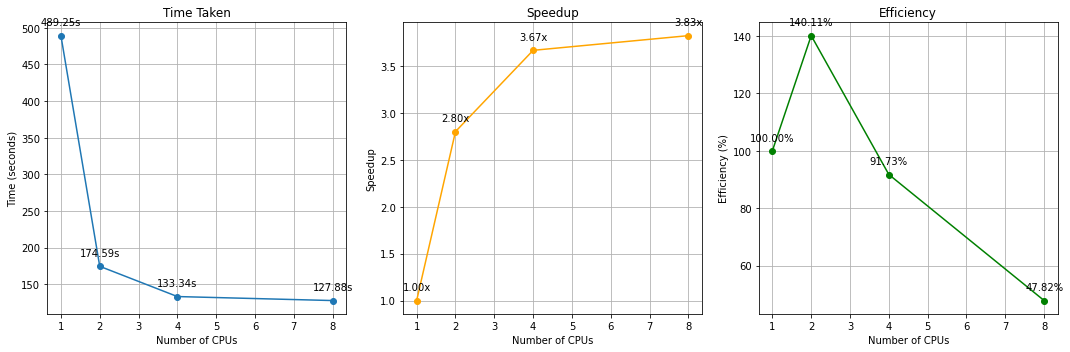

In [12]:
speedup_train = [time_taken_train[0] / t for t in time_taken_train]
efficiency_train = [(s / c) * 100 for s, c in zip(speedup_train, cpu_counts)]

# Plotting the time taken with values displayed
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(cpu_counts, time_taken_train, marker='o')
for i, txt in enumerate(time_taken_train):
    plt.annotate(f"{txt:.2f}s", (cpu_counts[i], time_taken_train[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Time Taken")
plt.xlabel("Number of CPUs")
plt.ylabel("Time (seconds)")
plt.grid(True)

# Plotting the speedup with values displayed
plt.subplot(1, 3, 2)
plt.plot(cpu_counts, speedup_train, marker='o', color='orange')
for i, txt in enumerate(speedup_train):
    plt.annotate(f"{txt:.2f}x", (cpu_counts[i], speedup_train[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Speedup")
plt.xlabel("Number of CPUs")
plt.ylabel("Speedup")
plt.grid(True)

# Plotting the efficiency with values displayed
plt.subplot(1, 3, 3)
plt.plot(cpu_counts, efficiency_train, marker='o', color='green')
for i, txt in enumerate(efficiency_train):
    plt.annotate(f"{txt:.2f}%", (cpu_counts[i], efficiency_train[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Efficiency")
plt.xlabel("Number of CPUs")
plt.ylabel("Efficiency (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
cnv_data= r"/home/venugopalbalamurug.l/Dataset/train/CNV"
print("CNV images :\n" ,os.listdir(cnv_data)[:5])

dme_data= r"/home/venugopalbalamurug.l/Dataset/train/DME"
print("\nDME images :\n" ,os.listdir(dme_data)[:5])

drusen_data= r"/home/venugopalbalamurug.l/Dataset/train/DRUSEN"
print("\nDRUSEN images :\n" ,os.listdir(drusen_data)[:5])

normal_data= r"/home/venugopalbalamurug.l/Dataset/train/NORMAL"
print("\npNormal images :\n" ,os.listdir(normal_data)[:5])

CNV images :
 ['CNV-1016042-100.jpeg', 'CNV-1016042-101.jpeg', 'CNV-1016042-106.jpeg', 'CNV-1016042-107.jpeg', 'CNV-1016042-11.jpeg']

DME images :
 ['DME-1072015-1.jpeg', 'DME-1072015-2.jpeg', 'DME-1072015-3.jpeg', 'DME-1072015-4.jpeg', 'DME-1072015-5.jpeg']

DRUSEN images :
 ['DRUSEN-1001666-1.jpeg', 'DRUSEN-1001666-2.jpeg', 'DRUSEN-1001666-3.jpeg', 'DRUSEN-1001666-4.jpeg', 'DRUSEN-1001666-5.jpeg']

pNormal images :
 ['NORMAL-1001772-8.jpeg', 'NORMAL-1004480-10.jpeg', 'NORMAL-1004480-11.jpeg', 'NORMAL-1004480-12.jpeg', 'NORMAL-1004480-13.jpeg']


#### Balanced Training Data

In [14]:
print("Image count after class balancing")
print("\nno. of CNV images :" ,len(os.listdir(cnv_data)))
print("\nno. of DME images :" ,len(os.listdir(dme_data)))
print("\nno. of DRUSEN images :" ,len(os.listdir(drusen_data)))
print("\nno. of Normal images :" ,len(os.listdir(normal_data)))

Image count after class balancing

no. of CNV images : 8616

no. of DME images : 8616

no. of DRUSEN images : 8616

no. of Normal images : 8616


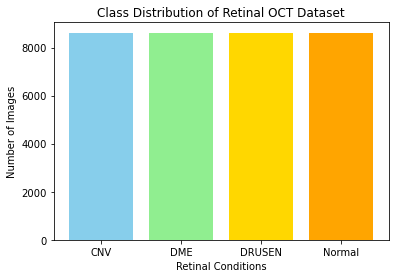

In [15]:
# Count the number of images in each class
cnv_count = len(os.listdir(cnv_data))
dme_count = len(os.listdir(dme_data))
drusen_count = len(os.listdir(drusen_data))
normal_count = len(os.listdir(normal_data))

# Class labels and counts
class_labels = ['CNV', 'DME', 'DRUSEN', 'Normal']
class_counts = [cnv_count, dme_count, drusen_count, normal_count]

# Create a bar plot
plt.bar(class_labels, class_counts, color=['skyblue', 'lightgreen', 'gold', 'orange'])
plt.xlabel('Retinal Conditions')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Retinal OCT Dataset')
plt.show()


The bar chart represents the balanced class distribution of the retinal OCT dataset, indicating an equal number of images across four categories—CNV, DME, DRUSEN, and Normal—demonstrating successful data balancing for model training.

### ----- **Parallel** Data Preparation for Validation Set -----


#### Move 15% data from train directory to val directory

In [16]:
def move_images_to_validation(subfolder_args):
    train_dir, val_dir, subfolder, percent_to_move = subfolder_args
    folder_path = os.path.join(train_dir, subfolder)
    target_folder_path = os.path.join(val_dir, subfolder)
    os.makedirs(target_folder_path, exist_ok=True)

    images = os.listdir(folder_path)
    num_to_move = int(len(images) * percent_to_move)
    selected_images = random.sample(images, num_to_move)

    for image in selected_images:
        src_path = os.path.join(folder_path, image)
        dest_path = os.path.join(target_folder_path, image)
        shutil.move(src_path, dest_path)

In [17]:
def parallel_move_to_validation(train_dir, val_dir, subfolders, percent_to_move, n_processes):
    start_time = time.time()
    args = [(train_dir, val_dir, subfolder, percent_to_move) for subfolder in subfolders]

    with Pool(processes=n_processes) as pool:
        pool.map(move_images_to_validation, args)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken with {n_processes} processes: {elapsed_time} seconds\n")
    return elapsed_time

In [18]:
def restore_images_from_val_to_train(train_dir, val_dir, subfolder):
    val_subfolder_path = os.path.join(val_dir, subfolder)
    train_subfolder_path = os.path.join(train_dir, subfolder)

    if not os.path.exists(val_subfolder_path):
        return  # No images to restore

    for image in os.listdir(val_subfolder_path):
        src_path = os.path.join(val_subfolder_path, image)
        dest_path = os.path.join(train_subfolder_path, image)
        shutil.move(src_path, dest_path)  # Move back to train directory

In [19]:
# Set your paths and the percentage of data to move to validation
train_dir = "/home/venugopalbalamurug.l/Dataset/train"
val_dir = "/home/venugopalbalamurug.l/Dataset/val"
percent_to_move = 0.15  # 15% of data moved to validation

time_taken_val = []

for n in cpu_counts:
    if n == 1:
        # Clear the val directories only for the first run
        for class_name in classes:
            clear_target_directory(os.path.join(val_dir, class_name))
    else:
        # Restore images from val to train directory for each class
        for class_name in classes:
            restore_images_from_val_to_train(train_dir, val_dir, class_name)

    # Now run the validation image moving process
    elapsed_time_val = parallel_move_to_validation(train_dir, val_dir, classes, percent_to_move, n)
    time_taken_val.append(elapsed_time_val)

Time taken with 1 processes: 52.66943621635437 seconds

Time taken with 2 processes: 36.235971212387085 seconds

Time taken with 4 processes: 41.00085735321045 seconds

Time taken with 8 processes: 37.85051369667053 seconds



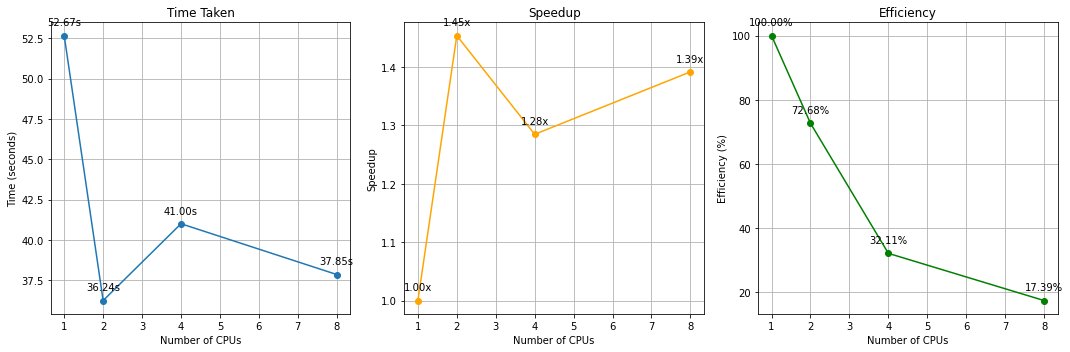

In [20]:
speedup_val = [time_taken_val[0] / t for t in time_taken_val]
efficiency_val = [(s / c) * 100 for s, c in zip(speedup_val, cpu_counts)]

# Plotting the time taken with values displayed
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(cpu_counts, time_taken_val, marker='o')
for i, txt in enumerate(time_taken_val):
    plt.annotate(f"{txt:.2f}s", (cpu_counts[i], time_taken_val[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Time Taken")
plt.xlabel("Number of CPUs")
plt.ylabel("Time (seconds)")
plt.grid(True)

# Plotting the speedup with values displayed
plt.subplot(1, 3, 2)
plt.plot(cpu_counts, speedup_val, marker='o', color='orange')
for i, txt in enumerate(speedup_val):
    plt.annotate(f"{txt:.2f}x", (cpu_counts[i], speedup_val[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Speedup")
plt.xlabel("Number of CPUs")
plt.ylabel("Speedup")
plt.grid(True)

# Plotting the efficiency with values displayed
plt.subplot(1, 3, 3)
plt.plot(cpu_counts, efficiency_val, marker='o', color='green')
for i, txt in enumerate(efficiency_val):
    plt.annotate(f"{txt:.2f}%", (cpu_counts[i], efficiency_val[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Efficiency")
plt.xlabel("Number of CPUs")
plt.ylabel("Efficiency (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

### ----- **Parallel** Copying of Test Data -----


#### Move test data from main directory to test directory

In [21]:
def copy_test_class_files(class_args):
    class_name, source_test_dir, target_test_dir = class_args
    source_class_dir = os.path.join(source_test_dir, class_name)
    target_class_dir = os.path.join(target_test_dir, class_name)

    # Create the class directory in the target directory if it doesn't exist
    os.makedirs(target_class_dir, exist_ok=True)

    # Copy all files from each class directory in the source to the target
    if os.path.exists(source_class_dir):
        for file in os.listdir(source_class_dir):
            source_file_path = os.path.join(source_class_dir, file)
            target_file_path = os.path.join(target_class_dir, file)

            # Ensure it's a file and does not already exist in the target directory
            if os.path.isfile(source_file_path) and not os.path.exists(target_file_path):
                shutil.copy(source_file_path, target_file_path)


In [22]:
def parallel_test_copy_to_target(source_test_dir, target_test_dir, classes, n_processes):
    start_time = time.time()
    
    args = [(class_name, source_test_dir, target_test_dir) for class_name in classes]
    with Pool(processes=n_processes) as pool:
        pool.map(copy_test_class_files, args)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken with {n_processes} processes: {elapsed_time} seconds\n")
    return elapsed_time

In [23]:
source_test_dir = "/home/venugopalbalamurug.l/kaggle/www.kaggle.com/datasets/paultimothymooney/kermany2018/OCT2017 /test/"
target_test_dir = "/home/venugopalbalamurug.l/Dataset/test/"
time_taken_test = []

for n in cpu_counts:
    for class_name in classes:
        clear_target_directory(os.path.join(target_test_dir, class_name))
    
    elapsed_time_test = parallel_test_copy_to_target(source_test_dir, target_test_dir, classes, n)
    time_taken_test.append(elapsed_time_test)

Time taken with 1 processes: 7.533128023147583 seconds

Time taken with 2 processes: 4.599627733230591 seconds

Time taken with 4 processes: 2.677917242050171 seconds

Time taken with 8 processes: 2.4785878658294678 seconds



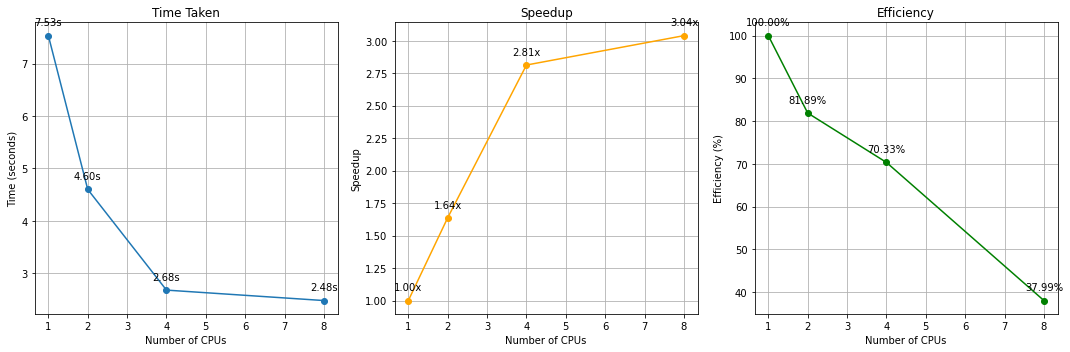

In [24]:
speedup_test = [time_taken_test[0] / t for t in time_taken_test]
efficiency_test = [(s / c) * 100 for s, c in zip(speedup_test, cpu_counts)]

# Plotting the time taken with values displayed
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(cpu_counts, time_taken_test, marker='o')
for i, txt in enumerate(time_taken_test):
    plt.annotate(f"{txt:.2f}s", (cpu_counts[i], time_taken_test[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Time Taken")
plt.xlabel("Number of CPUs")
plt.ylabel("Time (seconds)")
plt.grid(True)

# Plotting the speedup with values displayed
plt.subplot(1, 3, 2)
plt.plot(cpu_counts, speedup_test, marker='o', color='orange')
for i, txt in enumerate(speedup_test):
    plt.annotate(f"{txt:.2f}x", (cpu_counts[i], speedup_test[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Speedup")
plt.xlabel("Number of CPUs")
plt.ylabel("Speedup")
plt.grid(True)

# Plotting the efficiency with values displayed
plt.subplot(1, 3, 3)
plt.plot(cpu_counts, efficiency_test, marker='o', color='green')
for i, txt in enumerate(efficiency_test):
    plt.annotate(f"{txt:.2f}%", (cpu_counts[i], efficiency_test[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title("Efficiency")
plt.xlabel("Number of CPUs")
plt.ylabel("Efficiency (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

### ----- Overview of Final Dataset Structure -----


In [25]:
import os

# Define the directory paths
train_dir = "/home/venugopalbalamurug.l/Dataset/train/"
val_dir = "/home/venugopalbalamurug.l/Dataset/val/"
test_dir = "/home/venugopalbalamurug.l/Dataset/test/"

# Define the subfolders
subfolders = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Initialize a dictionary to store the file counts
file_counts = {
    'train': {subfolder: 0 for subfolder in subfolders},
    'val': {subfolder: 0 for subfolder in subfolders},
    'test': {subfolder: 0 for subfolder in subfolders}
}

# Function to count files in a directory
def count_files_in_directory(directory, subfolder_name):
    subfolder_path = os.path.join(directory, subfolder_name)
    if os.path.exists(subfolder_path):
        return len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
    else:
        return 0

# Count the number of files in each class within each directory
for subfolder in subfolders:
    file_counts['train'][subfolder] = count_files_in_directory(train_dir, subfolder)
    file_counts['val'][subfolder] = count_files_in_directory(val_dir, subfolder)
    file_counts['test'][subfolder] = count_files_in_directory(test_dir, subfolder)

print(file_counts)


{'train': {'CNV': 7324, 'DME': 7324, 'DRUSEN': 7324, 'NORMAL': 7324}, 'val': {'CNV': 1292, 'DME': 1292, 'DRUSEN': 1292, 'NORMAL': 1292}, 'test': {'CNV': 242, 'DME': 242, 'DRUSEN': 242, 'NORMAL': 242}}


The output shows a balanced distribution of images across the classes for each dataset, which is essential for training unbiased and well-generalized machine learning models.

#### ----- Display Sample Images from Each Category -----


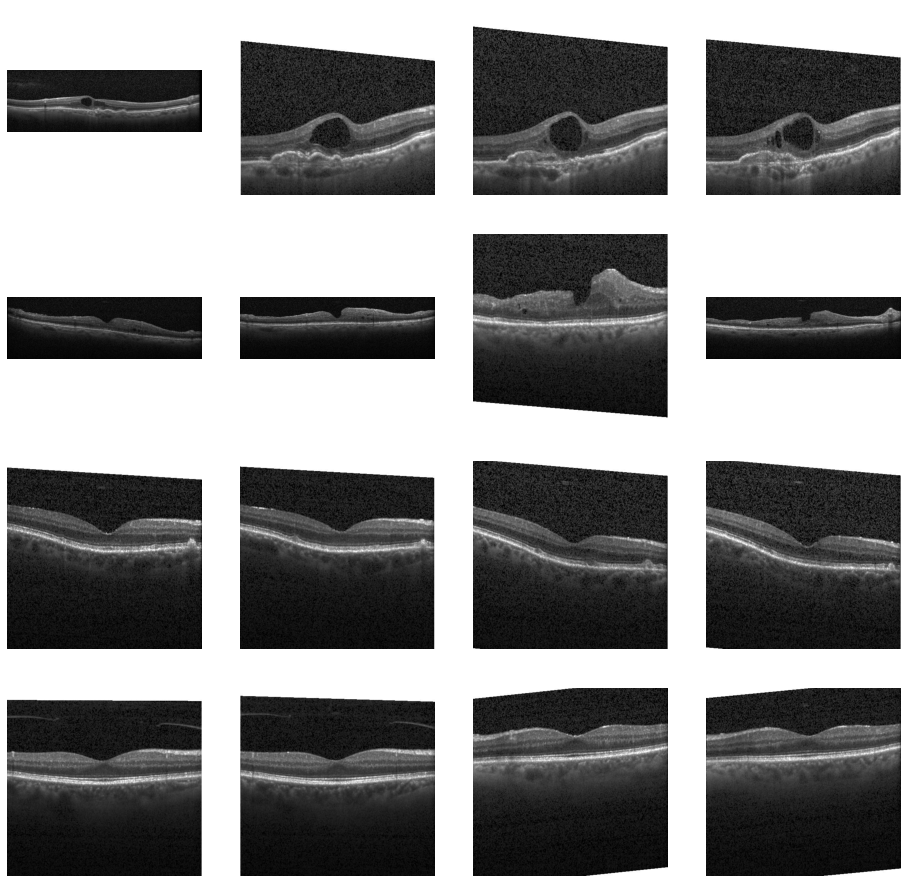

In [26]:
nrows = 4
ncols = 4
pic_index = 0

# Assuming cnv_data, dme_data, drusen_data, normal_data are defined and point to the respective directories
cnv_img = [os.path.join(cnv_data, image) for image in os.listdir(cnv_data)[pic_index:pic_index+ncols]]
dme_img = [os.path.join(dme_data, image) for image in os.listdir(dme_data)[pic_index:pic_index+ncols]]
drusen_img = [os.path.join(drusen_data, image) for image in os.listdir(drusen_data)[pic_index:pic_index+ncols]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index:pic_index+ncols]]

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# Arrange images by class per row
images_by_row = cnv_img + dme_img + drusen_img + normal_img

for i, image_path in enumerate(images_by_row):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(image_path)
    plt.imshow(img, cmap='gray')

plt.show()

The grid of images displayed represents a sample from each category of the retinal OCT dataset, showcasing the distinct features of CNV, DME, DRUSEN, and NORMAL retinal conditions. This visualization aids in understanding the variations and commonalities within the classes, which is crucial for developing accurate diagnostic models.

#### ----- Basic Visualization of OCT Images by Category -----

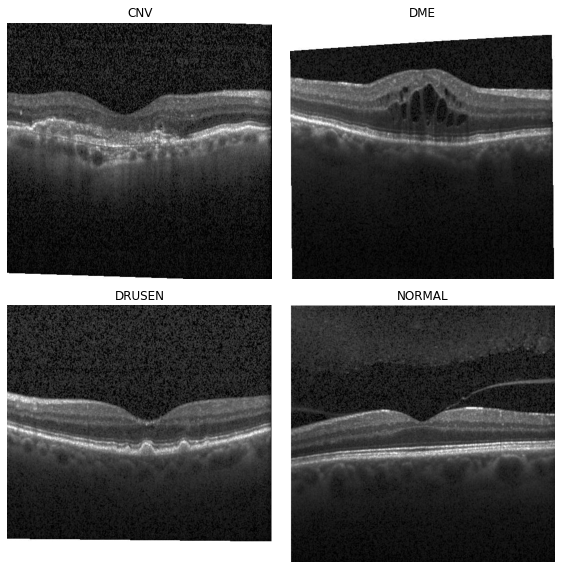

In [27]:
import cv2
import matplotlib.pyplot as plt

# List of example OCT image paths for CNV, DME, DRUSEN, and NORMAL
image_paths = [
    '/home/venugopalbalamurug.l/Dataset/test/CNV/CNV-1016042-1.jpeg',
    '/home/venugopalbalamurug.l/Dataset/test/DME/DME-1081406-1.jpeg',
    '/home/venugopalbalamurug.l/Dataset/test/DRUSEN/DRUSEN-1083159-1.jpeg',
    '/home/venugopalbalamurug.l/Dataset/test/NORMAL/NORMAL-1017237-1.jpeg'
]

# Corresponding titles for each category
category_titles = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# Iterate over the images and display them in the grid
for i, (image_path, category_title) in enumerate(zip(image_paths, category_titles)):
    # Load the OCT image
    oct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if oct_image is not None:
        # Convert the image to a NumPy array with a float dtype
        oct_image = oct_image.astype(float)

        # Display the image in the corresponding subplot with title
        row = i // 2
        col = i % 2
        axes[row, col].imshow(oct_image, cmap='gray')
        axes[row, col].set_title(category_title)
        axes[row, col].axis('off')
    else:
        print(f"Failed to load image from path: {image_path}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


#### ----- Enhancing OCT Image Quality for Improved Visibility -----

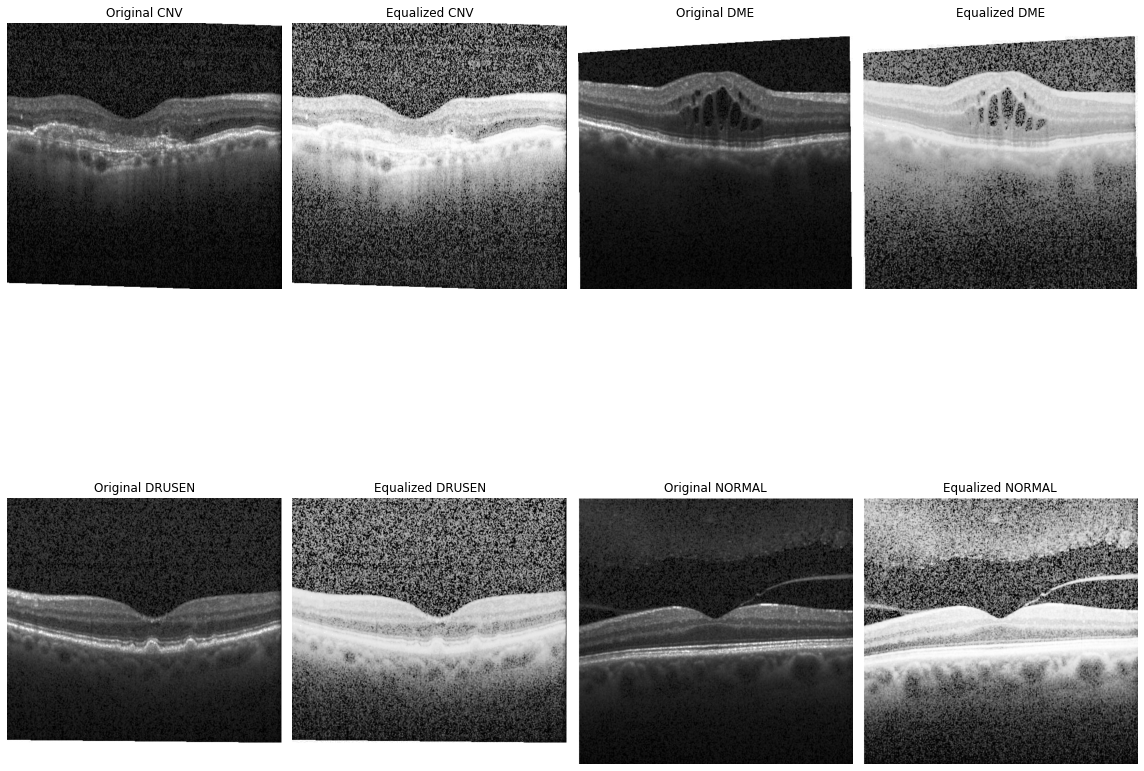

In [28]:
from skimage import exposure

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 16))

# Iterate over the images and display the original and equalized versions
for i, (image_path, category_title) in enumerate(zip(image_paths, category_titles)):
    # Load the OCT image
    oct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if oct_image is not None:
        # Convert the image to a NumPy array with a float dtype
        oct_image = oct_image.astype(float)

        # Apply histogram equalization for contrast enhancement
        oct_image_equalized = exposure.equalize_hist(oct_image)

        # Display the original image in the first column
        row = i // 2
        col = i % 2
        axes[row, col * 2].imshow(oct_image, cmap='gray')
        axes[row, col * 2].set_title(f'Original {category_title}')
        axes[row, col * 2].axis('off')

        # Display the equalized image in the second column
        axes[row, col * 2 + 1].imshow(oct_image_equalized, cmap='gray')
        axes[row, col * 2 + 1].set_title(f'Equalized {category_title}')
        axes[row, col * 2 + 1].axis('off')
    else:
        print(f"Failed to load image from path: {image_path}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


**Insight** : The images demonstrate the effect of histogram equalization on OCT images for the categories of CNV, DME, DRUSEN, and NORMAL. The equalization process enhances the contrast, making the structural details within each image more visible and distinct.

#### ----- Binary Segmentation of OCT Images for Highlighting Features -----

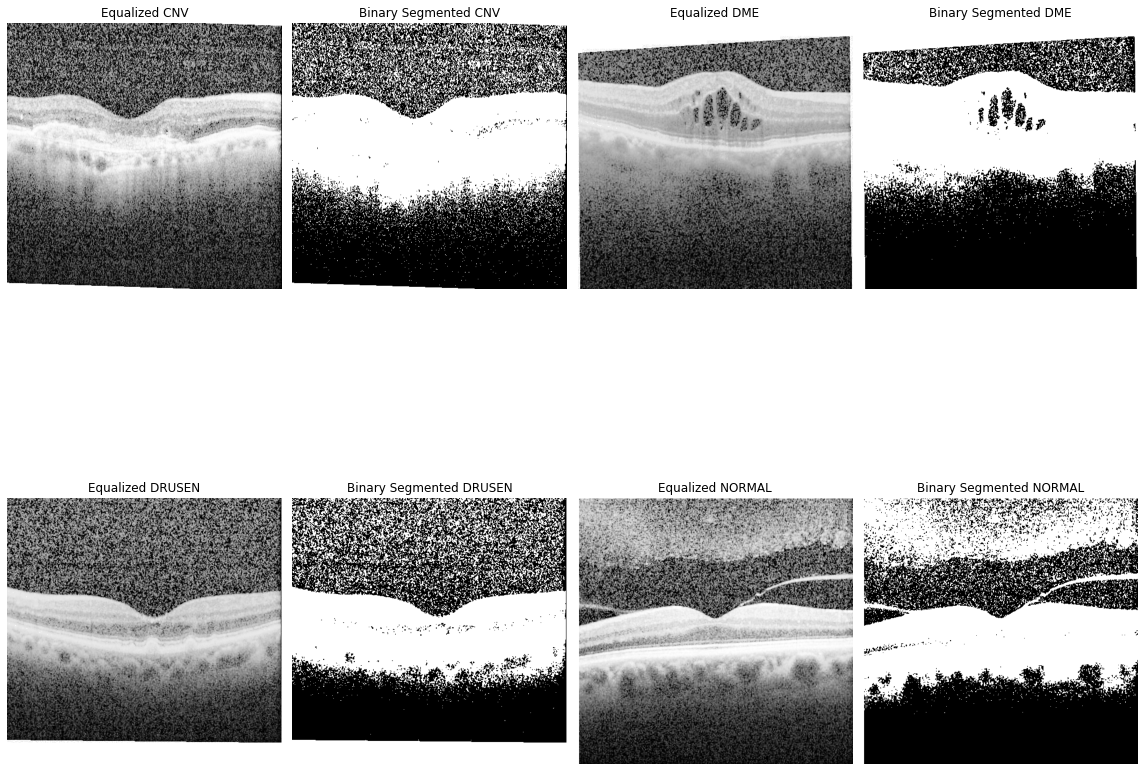

In [29]:
from skimage import exposure, filters
from skimage.filters import threshold_otsu

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 16))

# Iterate over the images and display the original, equalized, and binary segmented versions
for i, (image_path, category_title) in enumerate(zip(image_paths, category_titles)):
    # Load the OCT image
    oct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if oct_image is not None:
        # Convert the image to a NumPy array with a float dtype
        oct_image = oct_image.astype(float)

        # Apply histogram equalization for contrast enhancement
        oct_image_equalized = exposure.equalize_hist(oct_image)

        # Apply Otsu's thresholding
        threshold_value = threshold_otsu(oct_image_equalized)
        binary_image = oct_image_equalized > threshold_value

        # Display the equalized image in the first column
        row = i // 2
        col = i % 2
        axes[row, col * 2].imshow(oct_image_equalized, cmap='gray')
        axes[row, col * 2].set_title(f'Equalized {category_title}')
        axes[row, col * 2].axis('off')

        # Display the binary segmented image in the second column
        axes[row, col * 2 + 1].imshow(binary_image, cmap='gray')
        axes[row, col * 2 + 1].set_title(f'Binary Segmented {category_title}')
        axes[row, col * 2 + 1].axis('off')
    else:
        print(f"Failed to load image from path: {image_path}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


**Insight** : The comparison between the equalized and binary segmented OCT images for each category illustrates the power of thresholding techniques in medical image processing. Through binary segmentation, specific features within the OCT images are highlighted, distinguishing the areas of clinical interest from the background. This process is crucial for identifying and analyzing pathological changes.

#### ----- Overlaying Segmented Regions on Original Images -----

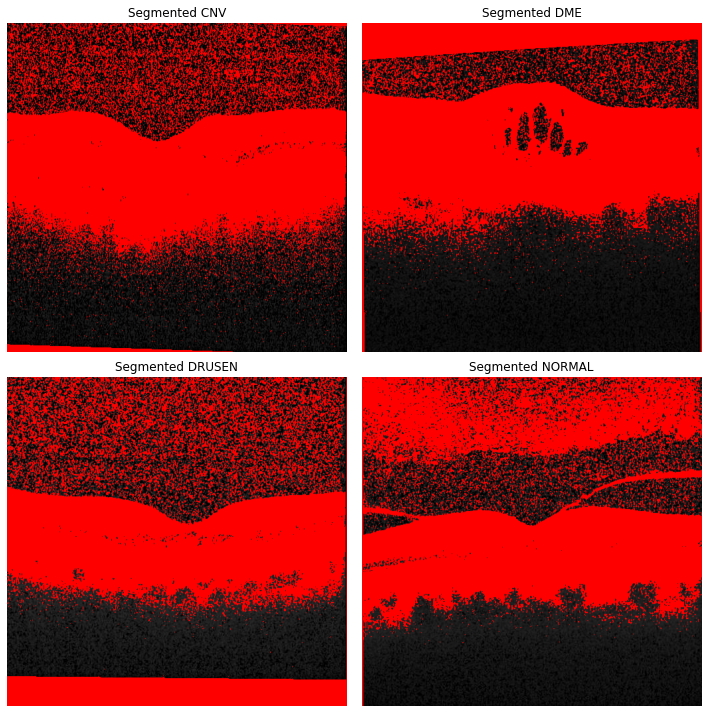

In [30]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate over the images and display the original, equalized, and binary segmented versions
for i, (image_path, category_title) in enumerate(zip(image_paths, category_titles)):
    # Load the OCT image
    oct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if oct_image is not None:
        # Convert the image to a NumPy array with a float dtype
        oct_image = oct_image.astype(float)

        # Apply histogram equalization for contrast enhancement
        oct_image_equalized = exposure.equalize_hist(oct_image)

        # Apply Otsu's thresholding
        threshold_value = threshold_otsu(oct_image_equalized)
        binary_image = oct_image_equalized > threshold_value

        # Normalize the image to 8-bit unsigned integer (CV_8U)
        normalized_image = cv2.normalize(oct_image, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to 8-bit unsigned integer (CV_8U)
        oct_image_8u = cv2.convertScaleAbs(normalized_image)

        # Overlay segmented regions on the original image
        segmented_image = cv2.cvtColor(oct_image_8u, cv2.COLOR_GRAY2RGB)
        segmented_image[binary_image] = [255, 0, 0]  # Set segmented regions to red

        # Display the final segmented image
        row = i // 2
        col = i % 2
        axes[row, col].imshow(segmented_image)
        axes[row, col].set_title(f'Segmented {category_title}')
        axes[row, col].axis('off')
    else:
        print(f"Failed to load image from path: {image_path}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


**Insight** : Overlaying segmented regions on the original OCT images provides a clear visual differentiation between areas of potential pathology and normal tissue. This technique aids in emphasizing the regions of interest and can be especially useful for clinicians during the review process, as it allows for a quick identification of areas that may require further examination or intervention.

#### ----- Lesion Detection Using Connected Component Labeling -----


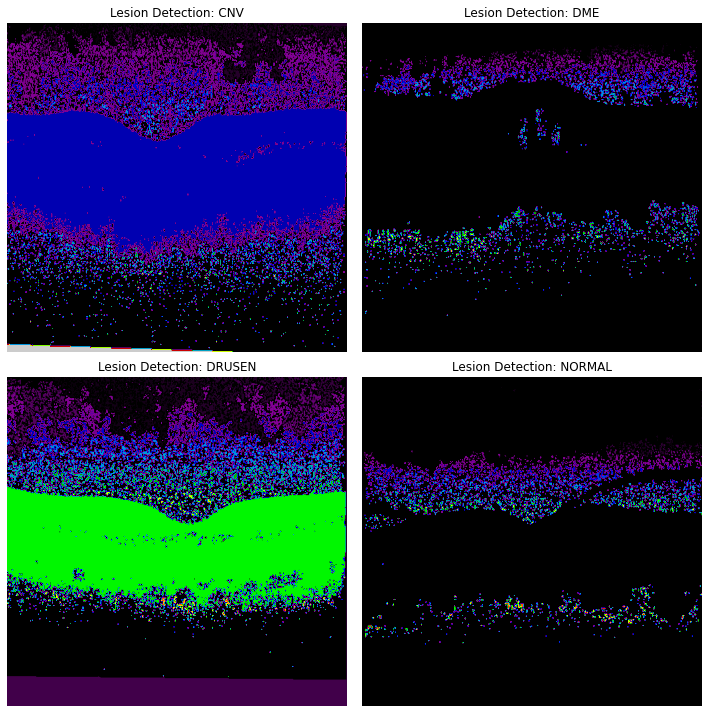

In [31]:
from skimage import measure

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate over the images and display the labeled images
for i, (image_path, category_title) in enumerate(zip(image_paths, category_titles)):
    # Load the OCT image
    oct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if oct_image is not None:
        # Convert the image to a NumPy array with a float dtype
        oct_image = oct_image.astype(float)

        # Apply histogram equalization for contrast enhancement
        oct_image_equalized = exposure.equalize_hist(oct_image)

        # Apply Otsu's thresholding
        threshold_value = threshold_otsu(oct_image_equalized)
        binary_image = oct_image_equalized > threshold_value

        # Label connected components in the binary image
        labeled_image = measure.label(binary_image)

        # Display the labeled image
        row = i // 2
        col = i % 2
        axes[row, col].imshow(labeled_image, cmap='nipy_spectral')
        axes[row, col].set_title(f'Lesion Detection: {category_title}')
        axes[row, col].axis('off')
    else:
        print(f"Failed to load image from path: {image_path}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


**Insight** : The use of connected component labeling in these OCT images has enabled the visualization of potential lesions within the retinal structure. The distinct coloration makes it easier to identify and differentiate various lesions, which could potentially assist in the automated analysis of retinal scans and aid ophthalmologists in diagnosing retinal diseases.

#### ----- Lesion Localization with Bounding Boxes -----

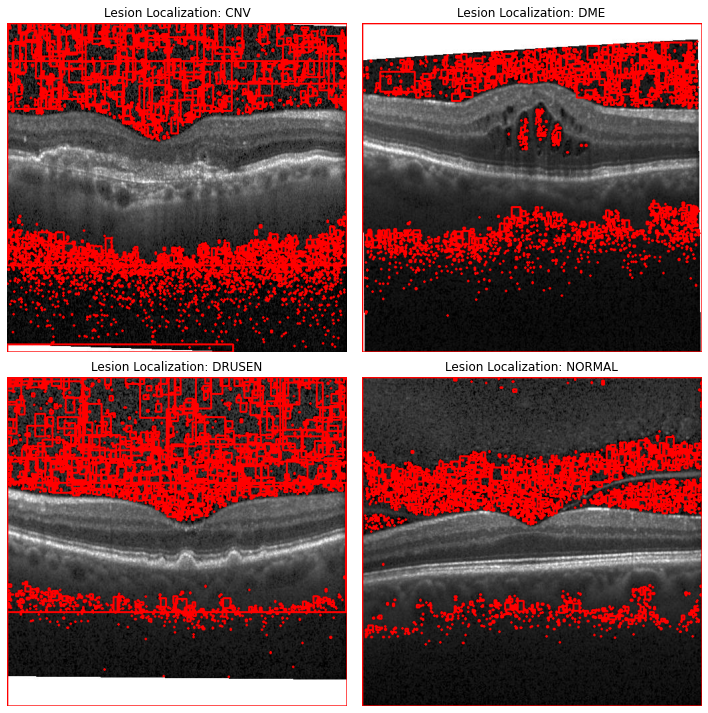

In [32]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate over the images and display images with detected lesions
for i, (image_path, category_title) in enumerate(zip(image_paths, category_titles)):
    # Load the OCT image
    oct_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image is loaded successfully
    if oct_image is not None:
        # Convert the image to a NumPy array with a float dtype
        oct_image = oct_image.astype(float)

        # Apply histogram equalization for contrast enhancement
        oct_image_equalized = exposure.equalize_hist(oct_image)

        # Apply Otsu's thresholding
        threshold_value = threshold_otsu(oct_image_equalized)
        binary_image = oct_image_equalized > threshold_value

        # Label connected components in the binary image
        labeled_image = measure.label(binary_image)

        # Normalize the image to 8-bit unsigned integer (CV_8U)
        normalized_image = cv2.normalize(oct_image, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to 8-bit unsigned integer (CV_8U)
        oct_image_8u = cv2.convertScaleAbs(normalized_image)

        # Extract region properties of labeled components
        regions = measure.regionprops(labeled_image)

        # Overlay bounding boxes around lesions on the original image
        detected_lesions_image = cv2.cvtColor(oct_image_8u, cv2.COLOR_GRAY2RGB)
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            cv2.rectangle(detected_lesions_image, (minc, minr), (maxc, maxr), (255, 0, 0), 2)

        # Display the image with detected lesions
        row = i // 2
        col = i % 2
        axes[row, col].imshow(detected_lesions_image)
        axes[row, col].set_title(f'Lesion Localization: {category_title}')
        axes[row, col].axis('off')
    else:
        print(f"Failed to load image from path: {image_path}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

**Insight** : The visualization showcases the effective use of bounding boxes in localizing lesions within OCT images. By applying histogram equalization and thresholding techniques, we can clearly delineate the areas of interest, marked in red, allowing for a more focused examination. 

### ----- Setting Up Environment and Importing Torch Libraries -----


In [33]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt

## ----- InceptionV3 Model -----

##### This section contains the output logs from the training process of the InceptionV3 model showing the progress over epochs, including training and validation loss and accuracy for different GPU configurations.

### 1) InceptionV3 Model Across 4 GPU Configurations (4 DataLoader Workers) :

The following scripts are a comprehensive PyTorch-based pipeline designed for training the InceptionV3 model on multiple GPUs. It leverages distributed data parallelism across four workers to enhance computational efficiency and reduce training time. The code handles dataset preparation, model training, and evaluation, offering a robust solution for large-scale image classification tasks.
- **InceptionV3_4W.py** : Training InceptionV3 model across 4 GPU configurations with 4 Worker DataLoaders.
- **InceptionV3_8W.py** : Training InceptionV3 model across 4 GPU configurations with 8 Worker DataLoaders.
- **InceptionV3_12W.py** : Training InceptionV3 model across 4 GPU configurations with 12 Worker DataLoaders.

In [34]:
!python InceptionV3_4W.py

Training with 1 GPU(s)
Epoch 1/5
----------
Train Epoch 1/5: 100%|████████████████████████| 115/115 [01:57<00:00,  1.02s/it]
Train Loss: 1.1621 Acc: 0.7039 Rank: 0
Val Epoch 1/5: 100%|████████████████████████████| 21/21 [00:52<00:00,  2.50s/it]
Val Loss: 0.5000 Acc: 0.8117 Rank: 0
Epoch 2/5
----------
Train Epoch 2/5: 100%|████████████████████████| 115/115 [01:59<00:00,  1.04s/it]
Train Loss: 0.8749 Acc: 0.7956 Rank: 0
Val Epoch 2/5: 100%|████████████████████████████| 21/21 [00:41<00:00,  1.98s/it]
Val Loss: 0.4505 Acc: 0.8346 Rank: 0
Epoch 3/5
----------
Train Epoch 3/5: 100%|████████████████████████| 115/115 [01:50<00:00,  1.05it/s]
Train Loss: 0.7846 Acc: 0.8216 Rank: 0
Val Epoch 3/5: 100%|████████████████████████████| 21/21 [00:43<00:00,  2.07s/it]
Val Loss: 0.4323 Acc: 0.8417 Rank: 0
Epoch 4/5
----------
Train Epoch 4/5: 100%|████████████████████████| 115/115 [01:57<00:00,  1.02s/it]
Train Loss: 0.7308 Acc: 0.8353 Rank: 0
Val Epoch 4/5: 100%|████████████████████████████| 21/21 [00

#### -- Plotting Training Metrics --


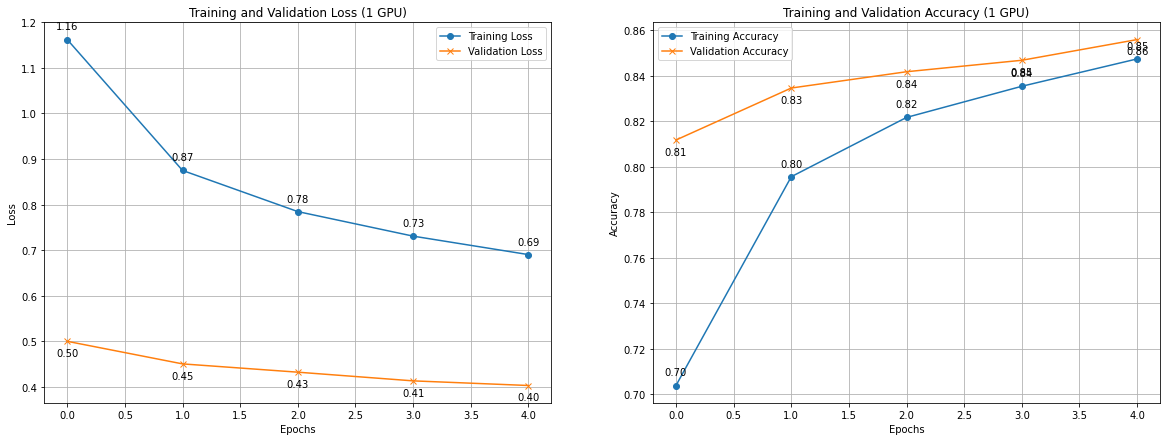

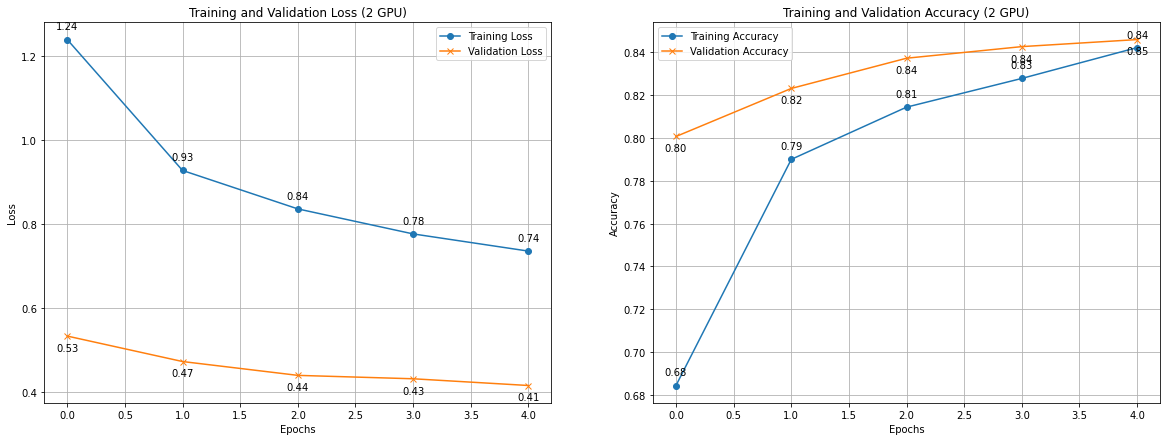

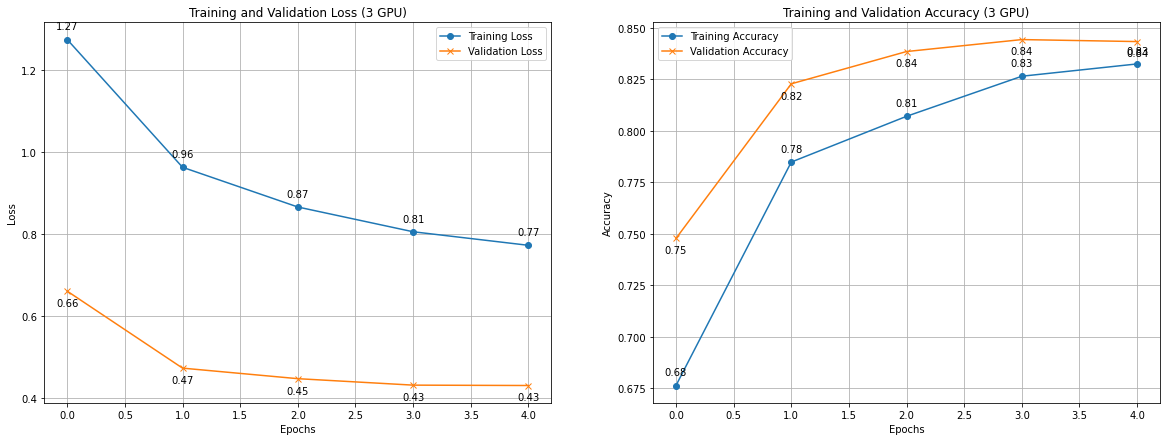

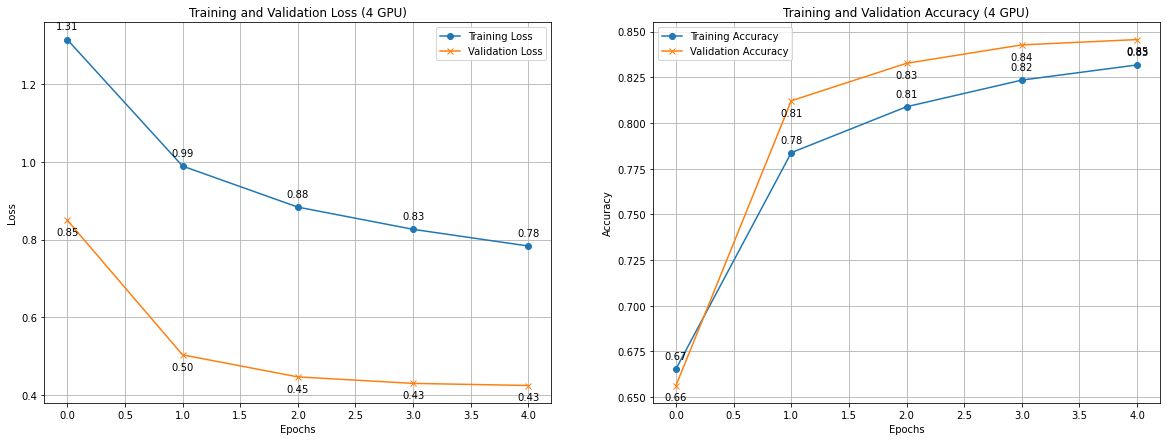

In [35]:
# Function to plot training and validation loss and accuracy
def plot_metrics(num_gpus):
    for i in range(1, num_gpus + 1):
        with open(f'InceptionV3_4W/training_metrics_{i}g_4w.json', 'r') as f:
            metrics = json.load(f)

            train_losses = metrics['train_loss']
            val_losses = metrics['val_loss']
            train_accs = metrics['train_acc']
            val_accs = metrics['val_acc']

            plt.figure(figsize=(20, 7))

            # Plotting Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='x')
            plt.title(f'Training and Validation Loss ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Loss plot
            for j, (tl, vl) in enumerate(zip(train_losses, val_losses)):
                plt.annotate(f"{tl:.2f}", (j, tl), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{vl:.2f}", (j, vl), textcoords="offset points", xytext=(0,-15), ha='center')

            # Plotting Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Training Accuracy', marker='o')
            plt.plot(val_accs, label='Validation Accuracy', marker='x')
            plt.title(f'Training and Validation Accuracy ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Accuracy plot
            for j, (ta, va) in enumerate(zip(train_accs, val_accs)):
                plt.annotate(f"{ta:.2f}", (j, ta), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{va:.2f}", (j, va), textcoords="offset points", xytext=(0,-15), ha='center')

            plt.show()

# Call the function after running the Python script
plot_metrics(4)

#### -- Training Time Comparison --

In [36]:
def get_training_times(num_gpus):
    times = []
    for i in range(1, num_gpus + 1):
        with open(f'InceptionV3_4W/training_metrics_{i}g_4w.json', 'r') as f:
            metrics = json.load(f)
            # Assuming 'time' is a list and you want the first element
            times.append(metrics['time'][0])
    return times

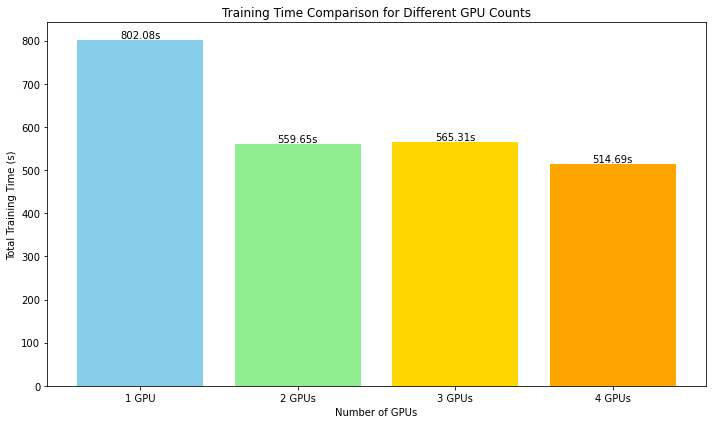

In [37]:
max_gpus = 4  # Define the maximum number of GPUs you've used for training
actual_training_times_1worker = get_training_times(max_gpus)
gpu_counts = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']

# Plotting the time comparison with actual times
plt.figure(figsize=(10, 6))
plt.bar(gpu_counts, actual_training_times_1worker, color=['skyblue', 'lightgreen', 'gold', 'orange'])

# Annotating the training times above each bar
for i, time in enumerate(actual_training_times_1worker):
    plt.text(i, time, f'{time:.2f}s', ha='center', va='bottom')

plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (s)')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### -- Speedup and Efficiency Analysis --


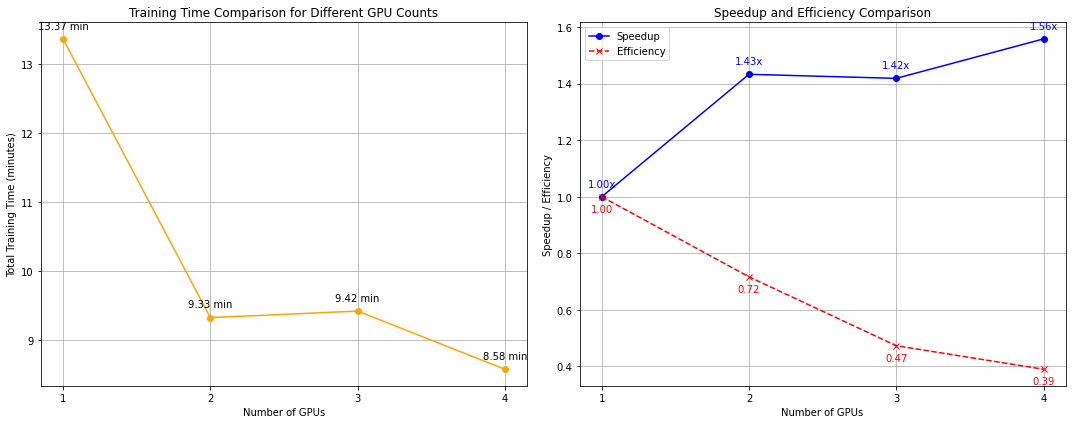

In [38]:
max_gpus = 4  # or the maximum number of GPUs you have data for
total_times = get_training_times(max_gpus)

# Convert times to minutes for plotting
times_in_minutes = [time / 60 for time in total_times]

# GPU counts
gpu_counts = list(range(1, max_gpus + 1))

# Calculate speedup based on the first entry as baseline
baseline_time = times_in_minutes[0]
speedups = [baseline_time / time for time in times_in_minutes]

# Calculate efficiency
efficiencies = [speedup / gpu for speedup, gpu in zip(speedups, gpu_counts)]

# Plotting the time comparison
plt.figure(figsize=(15, 6))

# Plotting Training Time
plt.subplot(1, 2, 1)
plt.plot(gpu_counts, times_in_minutes, marker='o', linestyle='-', color='orange')
plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (minutes)')
plt.xticks(gpu_counts)
plt.grid(True)

# Annotate training times
for i, time in enumerate(times_in_minutes):
    plt.annotate(f"{time:.2f} min", (gpu_counts[i], time), textcoords="offset points", xytext=(0,10), ha='center')

# Plotting Speedup and Efficiency
plt.subplot(1, 2, 2)
plt.plot(gpu_counts, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
plt.plot(gpu_counts, efficiencies, marker='x', linestyle='--', color='red', label='Efficiency')
plt.title('Speedup and Efficiency Comparison')
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup / Efficiency')
plt.xticks(gpu_counts)
plt.grid(True)
plt.legend()

# Annotate speedup and efficiency
for i, (s, e) in enumerate(zip(speedups, efficiencies)):
    plt.annotate(f"{s:.2f}x", (gpu_counts[i], s), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f"{e:.2f}", (gpu_counts[i], e), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()


#### -- Model Performance Evaluation --


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       242
           1       1.00      0.97      0.98       242
           2       0.94      0.99      0.96       242
           3       0.99      0.98      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



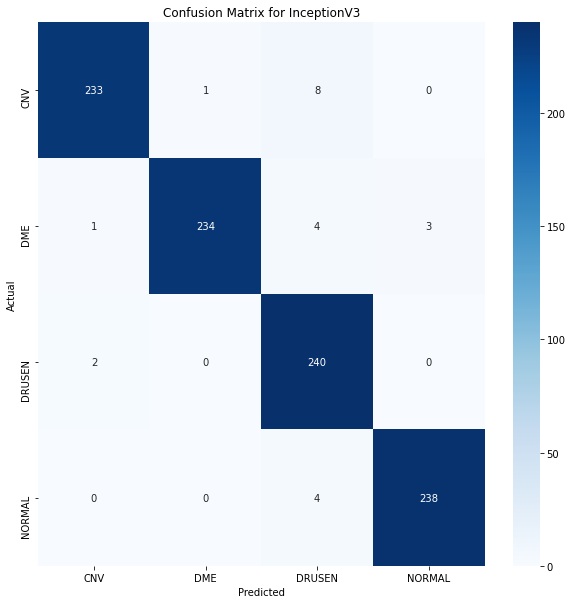

In [39]:
# Load predictions and labels
with open('InceptionV3_4W/model_predictions_4w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])

# Print classification report
print(classification_report(all_labels, all_preds))

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Plot confusion matrix
# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

### 2) InceptionV3 Model Across 4 GPU Configurations (8 DataLoader Workers) :

The following script is a comprehensive PyTorch-based pipeline designed for training the InceptionV3 model on multiple GPUs. It leverages distributed data parallelism across eight workers to enhance computational efficiency and reduce training time. The code handles dataset preparation, model training, and evaluation, offering a robust solution for large-scale image classification tasks. This is almost the same script as before, except we use 8 workers here.

In [40]:
!python InceptionV3_8W.py

Training with 1 GPU(s)
Epoch 1/5
----------
Train Epoch 1/5: 100%|████████████████████████| 115/115 [02:21<00:00,  1.23s/it]
Train Loss: 1.1672 Acc: 0.7037 Rank: 0
Val Epoch 1/5: 100%|████████████████████████████| 21/21 [01:05<00:00,  3.11s/it]
Val Loss: 0.5047 Acc: 0.8098 Rank: 0
Epoch 2/5
----------
Train Epoch 2/5: 100%|████████████████████████| 115/115 [02:17<00:00,  1.20s/it]
Train Loss: 0.8759 Acc: 0.7983 Rank: 0
Val Epoch 2/5: 100%|████████████████████████████| 21/21 [01:22<00:00,  3.92s/it]
Val Loss: 0.4481 Acc: 0.8303 Rank: 0
Epoch 3/5
----------
Train Epoch 3/5: 100%|████████████████████████| 115/115 [02:30<00:00,  1.31s/it]
Train Loss: 0.7842 Acc: 0.8230 Rank: 0
Val Epoch 3/5: 100%|████████████████████████████| 21/21 [01:07<00:00,  3.23s/it]
Val Loss: 0.4279 Acc: 0.8411 Rank: 0
Epoch 4/5
----------
Train Epoch 4/5: 100%|████████████████████████| 115/115 [02:18<00:00,  1.20s/it]
Train Loss: 0.7269 Acc: 0.8357 Rank: 0
Val Epoch 4/5: 100%|████████████████████████████| 21/21 [01

#### -- Plotting Training Metrics --


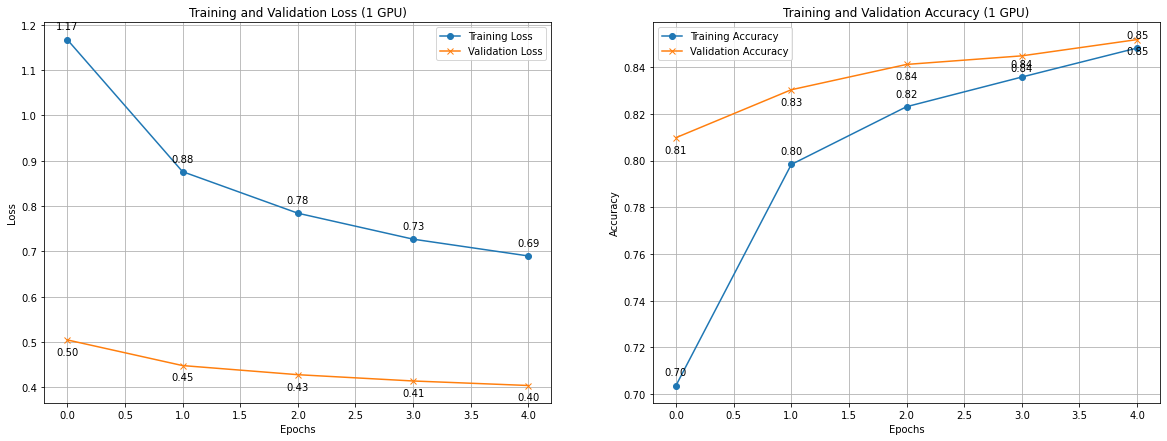

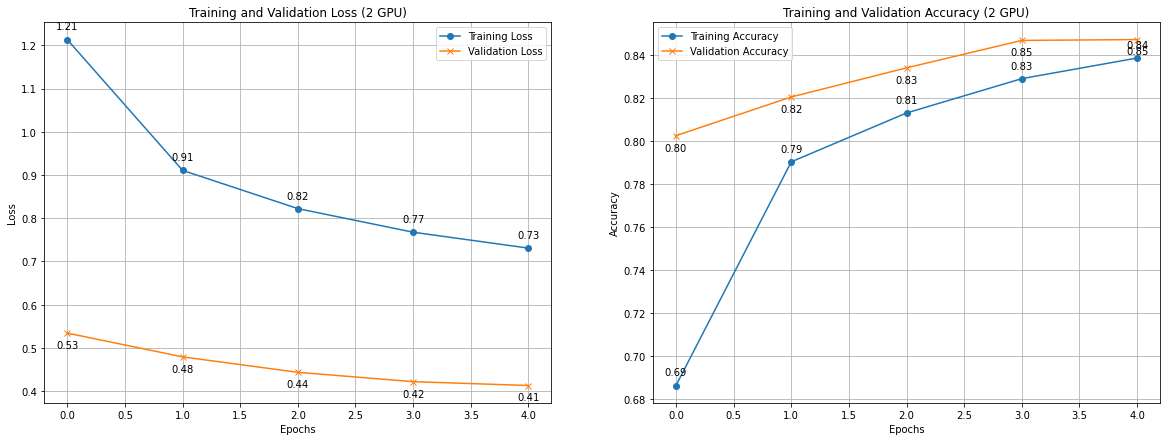

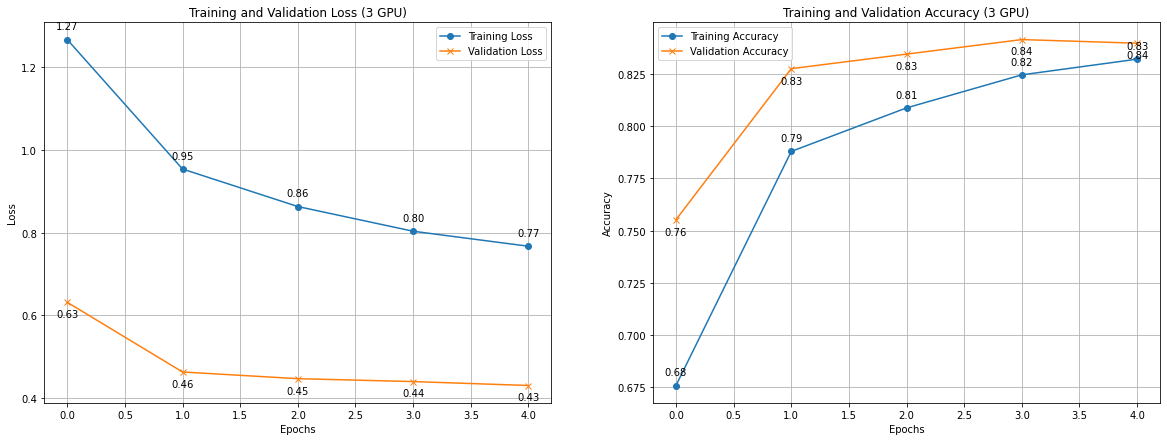

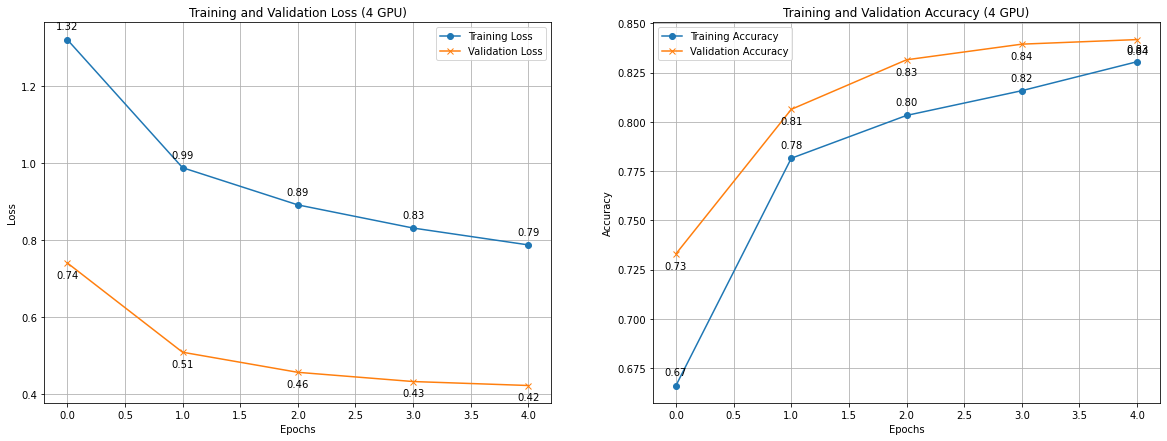

In [41]:
def plot_metrics(num_gpus):
    for i in range(1, num_gpus + 1):
        with open(f'InceptionV3_8W/training_metrics_{i}g_8w.json', 'r') as f:
            metrics = json.load(f)

            train_losses = metrics['train_loss']
            val_losses = metrics['val_loss']
            train_accs = metrics['train_acc']
            val_accs = metrics['val_acc']

            plt.figure(figsize=(20, 7))

            # Plotting Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='x')
            plt.title(f'Training and Validation Loss ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Loss plot
            for j, (tl, vl) in enumerate(zip(train_losses, val_losses)):
                plt.annotate(f"{tl:.2f}", (j, tl), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{vl:.2f}", (j, vl), textcoords="offset points", xytext=(0,-15), ha='center')

            # Plotting Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Training Accuracy', marker='o')
            plt.plot(val_accs, label='Validation Accuracy', marker='x')
            plt.title(f'Training and Validation Accuracy ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Accuracy plot
            for j, (ta, va) in enumerate(zip(train_accs, val_accs)):
                plt.annotate(f"{ta:.2f}", (j, ta), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{va:.2f}", (j, va), textcoords="offset points", xytext=(0,-15), ha='center')

            plt.show()

# Call the function after running the Python script
plot_metrics(4)

#### -- Training Time Comparison --

In [42]:
def get_training_times(num_gpus):
    times = []
    for i in range(1, num_gpus + 1):
        with open(f'InceptionV3_8W/training_metrics_{i}g_8w.json', 'r') as f:
            metrics = json.load(f)
            # Assuming 'time' is a list and you want the first element
            times.append(metrics['time'][0])
    return times

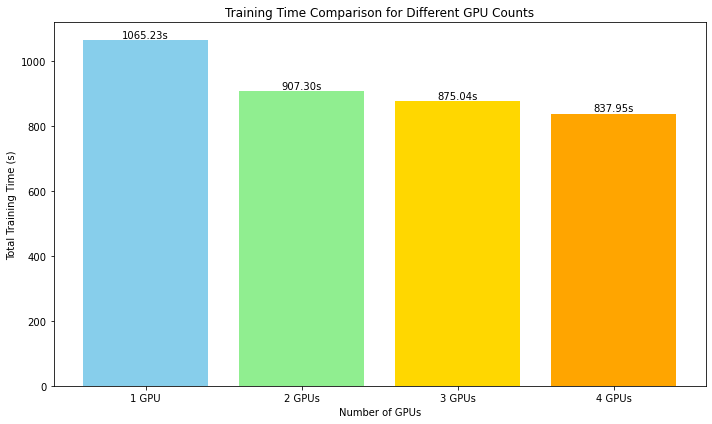

In [43]:
max_gpus = 4  # Define the maximum number of GPUs you've used for training
actual_training_times_1worker = get_training_times(max_gpus)
gpu_counts = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']

# Plotting the time comparison with actual times
plt.figure(figsize=(10, 6))
plt.bar(gpu_counts, actual_training_times_1worker, color=['skyblue', 'lightgreen', 'gold', 'orange'])

# Annotating the training times above each bar
for i, time in enumerate(actual_training_times_1worker):
    plt.text(i, time, f'{time:.2f}s', ha='center', va='bottom')

plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (s)')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### -- Speedup and Efficiency Analysis --


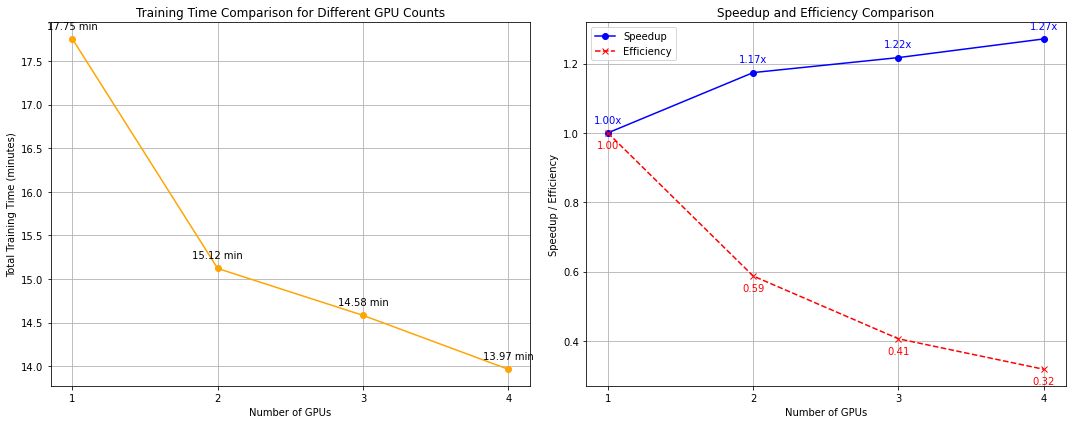

In [44]:
max_gpus = 4  # or the maximum number of GPUs you have data for
total_times = get_training_times(max_gpus)

# Convert times to minutes for plotting
times_in_minutes = [time / 60 for time in total_times]

# GPU counts
gpu_counts = list(range(1, max_gpus + 1))

# Calculate speedup based on the first entry as baseline
baseline_time = times_in_minutes[0]
speedups = [baseline_time / time for time in times_in_minutes]

# Calculate efficiency
efficiencies = [speedup / gpu for speedup, gpu in zip(speedups, gpu_counts)]

# Plotting the time comparison
plt.figure(figsize=(15, 6))

# Plotting Training Time
plt.subplot(1, 2, 1)
plt.plot(gpu_counts, times_in_minutes, marker='o', linestyle='-', color='orange')
plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (minutes)')
plt.xticks(gpu_counts)
plt.grid(True)

# Annotate training times
for i, time in enumerate(times_in_minutes):
    plt.annotate(f"{time:.2f} min", (gpu_counts[i], time), textcoords="offset points", xytext=(0,10), ha='center')

# Plotting Speedup and Efficiency
plt.subplot(1, 2, 2)
plt.plot(gpu_counts, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
plt.plot(gpu_counts, efficiencies, marker='x', linestyle='--', color='red', label='Efficiency')
plt.title('Speedup and Efficiency Comparison')
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup / Efficiency')
plt.xticks(gpu_counts)
plt.grid(True)
plt.legend()

# Annotate speedup and efficiency
for i, (s, e) in enumerate(zip(speedups, efficiencies)):
    plt.annotate(f"{s:.2f}x", (gpu_counts[i], s), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f"{e:.2f}", (gpu_counts[i], e), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()


#### -- Model Performance Evaluation --


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       242
           1       1.00      0.96      0.98       242
           2       0.95      1.00      0.97       242
           3       0.98      0.98      0.98       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



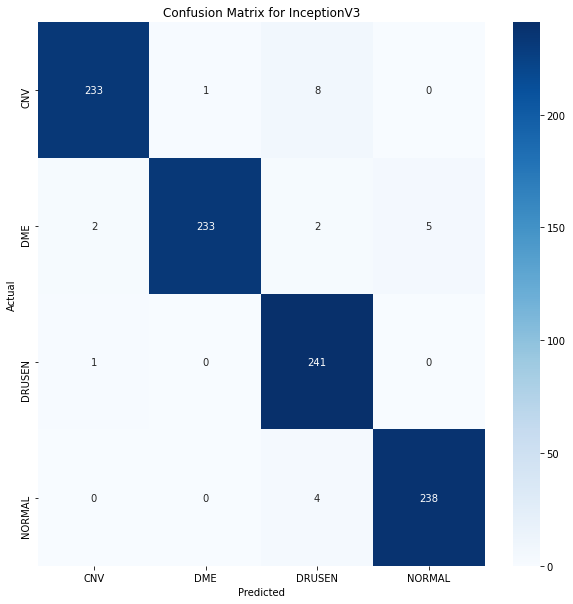

In [45]:
# Load predictions and labels
with open('InceptionV3_8W/model_predictions_8w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])

# Print classification report
print(classification_report(all_labels, all_preds))

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Plot confusion matrix
# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

### 3) InceptionV3 Model Across 4 GPU Configurations (12 DataLoader Workers) :

The following script is a comprehensive PyTorch-based pipeline designed for training the InceptionV3 model on multiple GPUs. It leverages distributed data parallelism across twelve workers to enhance computational efficiency and reduce training time. The code handles dataset preparation, model training, and evaluation, offering a robust solution for large-scale image classification tasks. This is almost the same script as before, except we use 12 workers here.

In [46]:
!python InceptionV3_12W.py

Training with 1 GPU(s)
Epoch 1/5
----------
Train Epoch 1/5: 100%|████████████████████████| 115/115 [03:06<00:00,  1.63s/it]
Train Loss: 1.1790 Acc: 0.6992 Rank: 0
Val Epoch 1/5: 100%|████████████████████████████| 21/21 [01:27<00:00,  4.17s/it]
Val Loss: 0.5054 Acc: 0.8082 Rank: 0
Epoch 2/5
----------
Train Epoch 2/5: 100%|████████████████████████| 115/115 [02:44<00:00,  1.43s/it]
Train Loss: 0.8801 Acc: 0.7931 Rank: 0
Val Epoch 2/5: 100%|████████████████████████████| 21/21 [01:30<00:00,  4.32s/it]
Val Loss: 0.4532 Acc: 0.8262 Rank: 0
Epoch 3/5
----------
Train Epoch 3/5: 100%|████████████████████████| 115/115 [03:03<00:00,  1.60s/it]
Train Loss: 0.7866 Acc: 0.8215 Rank: 0
Val Epoch 3/5: 100%|████████████████████████████| 21/21 [01:27<00:00,  4.19s/it]
Val Loss: 0.4219 Acc: 0.8435 Rank: 0
Epoch 4/5
----------
Train Epoch 4/5: 100%|████████████████████████| 115/115 [02:43<00:00,  1.43s/it]
Train Loss: 0.7325 Acc: 0.8344 Rank: 0
Val Epoch 4/5: 100%|████████████████████████████| 21/21 [01

#### -- Plotting Training Metrics --


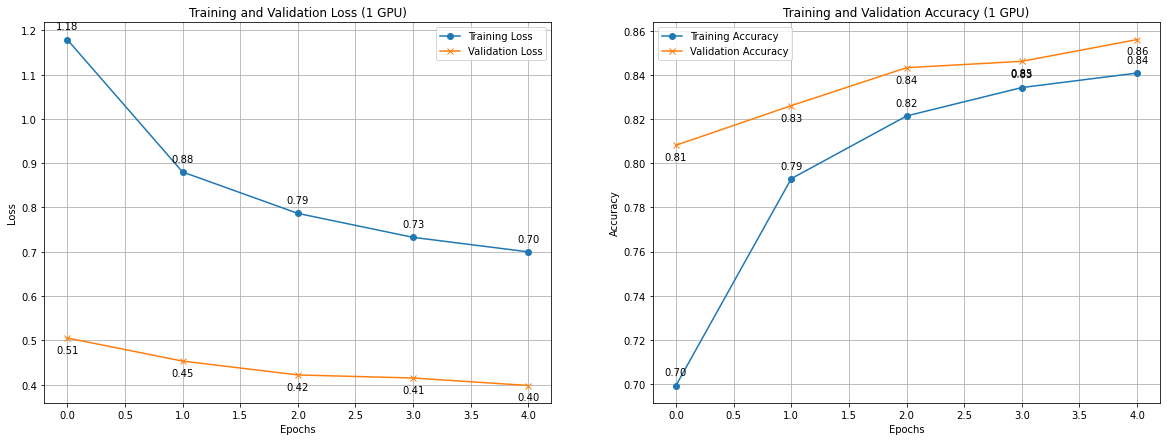

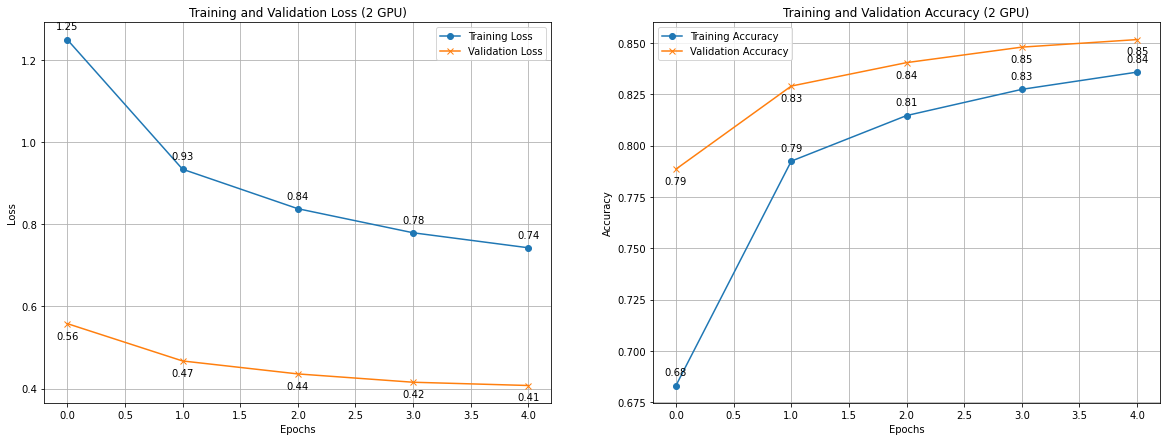

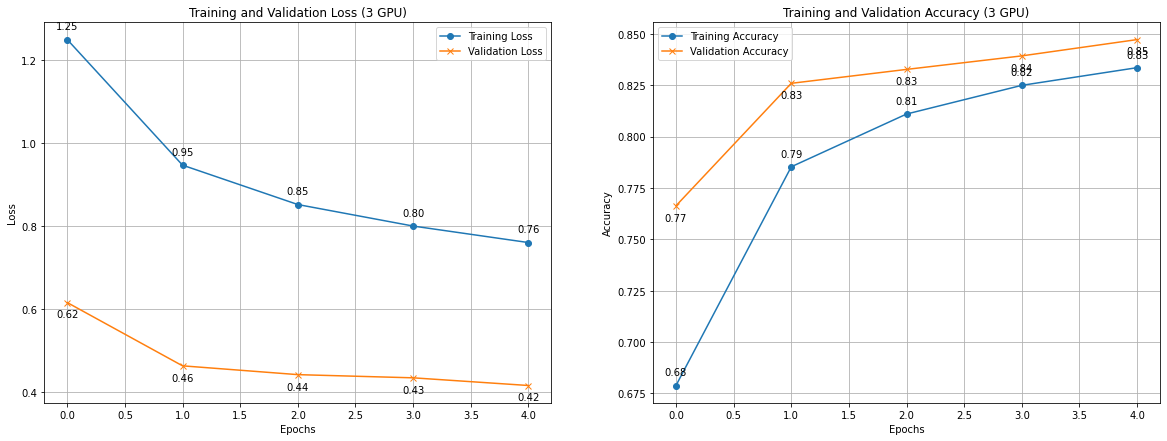

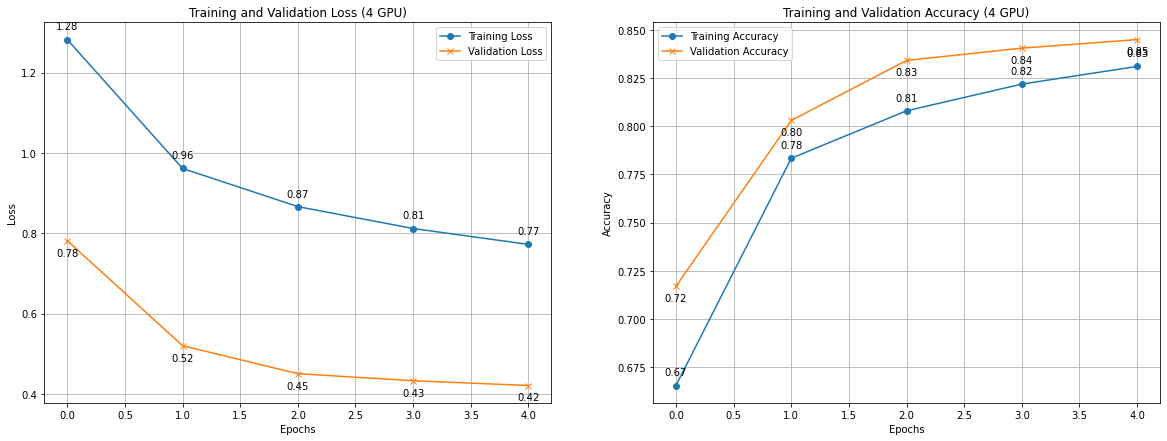

In [47]:
def plot_metrics(num_gpus):
    for i in range(1, num_gpus + 1):
        with open(f'InceptionV3_12W/training_metrics_{i}g_12w.json', 'r') as f:
            metrics = json.load(f)

            train_losses = metrics['train_loss']
            val_losses = metrics['val_loss']
            train_accs = metrics['train_acc']
            val_accs = metrics['val_acc']

            plt.figure(figsize=(20, 7))

            # Plotting Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='x')
            plt.title(f'Training and Validation Loss ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Loss plot
            for j, (tl, vl) in enumerate(zip(train_losses, val_losses)):
                plt.annotate(f"{tl:.2f}", (j, tl), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{vl:.2f}", (j, vl), textcoords="offset points", xytext=(0,-15), ha='center')

            # Plotting Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Training Accuracy', marker='o')
            plt.plot(val_accs, label='Validation Accuracy', marker='x')
            plt.title(f'Training and Validation Accuracy ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Accuracy plot
            for j, (ta, va) in enumerate(zip(train_accs, val_accs)):
                plt.annotate(f"{ta:.2f}", (j, ta), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{va:.2f}", (j, va), textcoords="offset points", xytext=(0,-15), ha='center')

            plt.show()

# Call the function after running the Python script
plot_metrics(4)

#### -- Training Time Comparison --

In [48]:
def get_training_times(num_gpus):
    times = []
    for i in range(1, num_gpus + 1):
        with open(f'InceptionV3_12W/training_metrics_{i}g_12w.json', 'r') as f:
            metrics = json.load(f)
            # Assuming 'time' is a list and you want the first element
            times.append(metrics['time'][0])
    return times

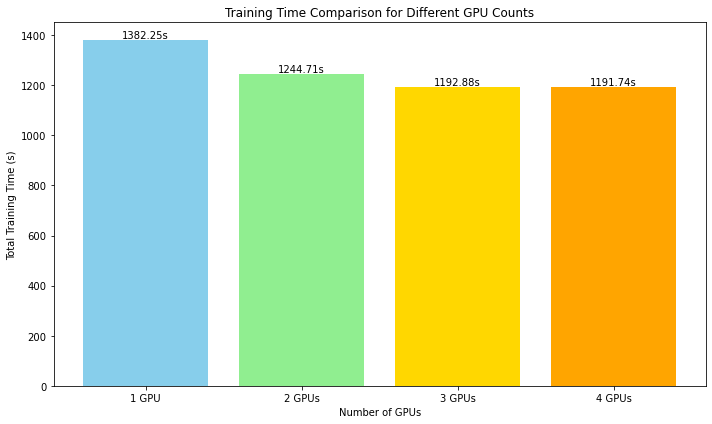

In [49]:
max_gpus = 4  # Define the maximum number of GPUs you've used for training
actual_training_times_1worker = get_training_times(max_gpus)
gpu_counts = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']

# Plotting the time comparison with actual times
plt.figure(figsize=(10, 6))
plt.bar(gpu_counts, actual_training_times_1worker, color=['skyblue', 'lightgreen', 'gold', 'orange'])

# Annotating the training times above each bar
for i, time in enumerate(actual_training_times_1worker):
    plt.text(i, time, f'{time:.2f}s', ha='center', va='bottom')

plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (s)')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### -- Speedup and Efficiency Analysis --


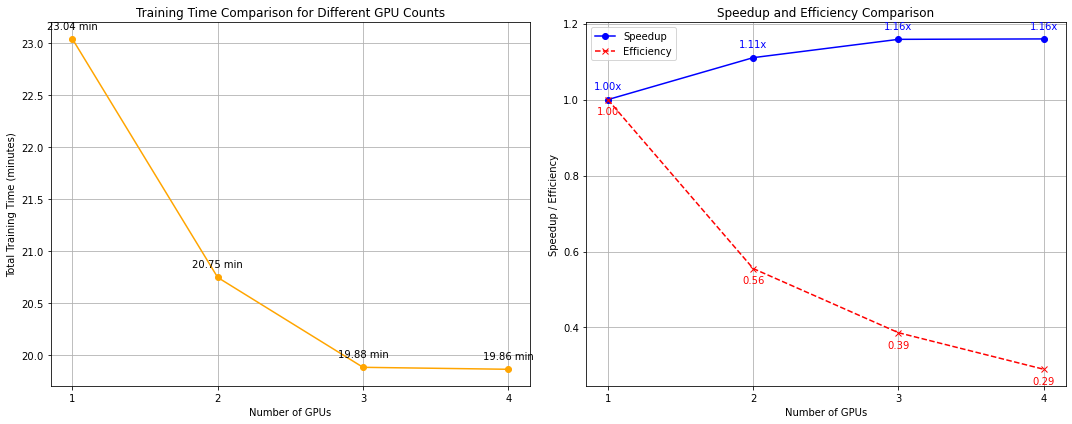

In [50]:
max_gpus = 4  # or the maximum number of GPUs you have data for
total_times = get_training_times(max_gpus)

# Convert times to minutes for plotting
times_in_minutes = [time / 60 for time in total_times]

# GPU counts
gpu_counts = list(range(1, max_gpus + 1))

# Calculate speedup based on the first entry as baseline
baseline_time = times_in_minutes[0]
speedups = [baseline_time / time for time in times_in_minutes]

# Calculate efficiency
efficiencies = [speedup / gpu for speedup, gpu in zip(speedups, gpu_counts)]

# Plotting the time comparison
plt.figure(figsize=(15, 6))

# Plotting Training Time
plt.subplot(1, 2, 1)
plt.plot(gpu_counts, times_in_minutes, marker='o', linestyle='-', color='orange')
plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (minutes)')
plt.xticks(gpu_counts)
plt.grid(True)

# Annotate training times
for i, time in enumerate(times_in_minutes):
    plt.annotate(f"{time:.2f} min", (gpu_counts[i], time), textcoords="offset points", xytext=(0,10), ha='center')

# Plotting Speedup and Efficiency
plt.subplot(1, 2, 2)
plt.plot(gpu_counts, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
plt.plot(gpu_counts, efficiencies, marker='x', linestyle='--', color='red', label='Efficiency')
plt.title('Speedup and Efficiency Comparison')
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup / Efficiency')
plt.xticks(gpu_counts)
plt.grid(True)
plt.legend()

# Annotate speedup and efficiency
for i, (s, e) in enumerate(zip(speedups, efficiencies)):
    plt.annotate(f"{s:.2f}x", (gpu_counts[i], s), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f"{e:.2f}", (gpu_counts[i], e), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()


#### -- Model Performance Evaluation --


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       242
           1       0.99      0.97      0.98       242
           2       0.96      0.99      0.98       242
           3       0.98      0.99      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



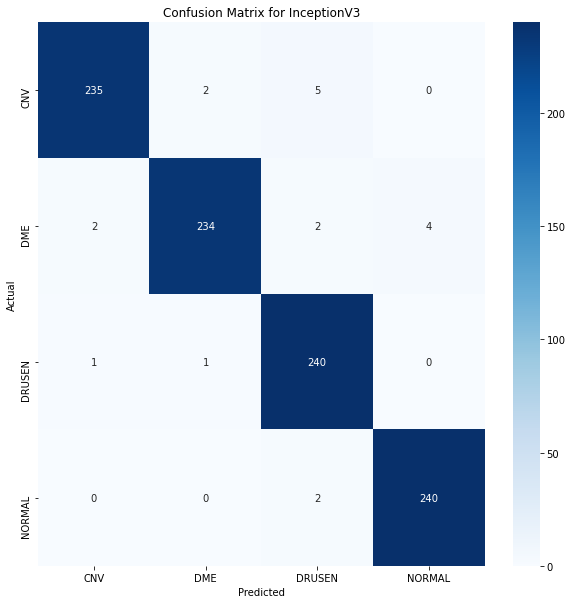

In [51]:
# Load predictions and labels
with open('InceptionV3_12W/model_predictions_12w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])

# Print classification report
print(classification_report(all_labels, all_preds))

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Plot confusion matrix
# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

## Comparison of Multiple GPUs Training Time Across Different Worker Settings (InceptionV3)

In [52]:
def get_training_times(num_gpus, num_workers_settings):
    times_dict = {}
    for gpu_count in range(1, num_gpus + 1):
        times = []
        for workers in num_workers_settings:
            filename = f'InceptionV3_{workers}W/training_metrics_{gpu_count}g_{workers}w.json'
            with open(filename, 'r') as f:
                metrics = json.load(f)
                times.append(metrics['time'][0])  # Assuming 'time' is the total training time
        times_dict[f'{gpu_count} GPU'] = times
    return times_dict

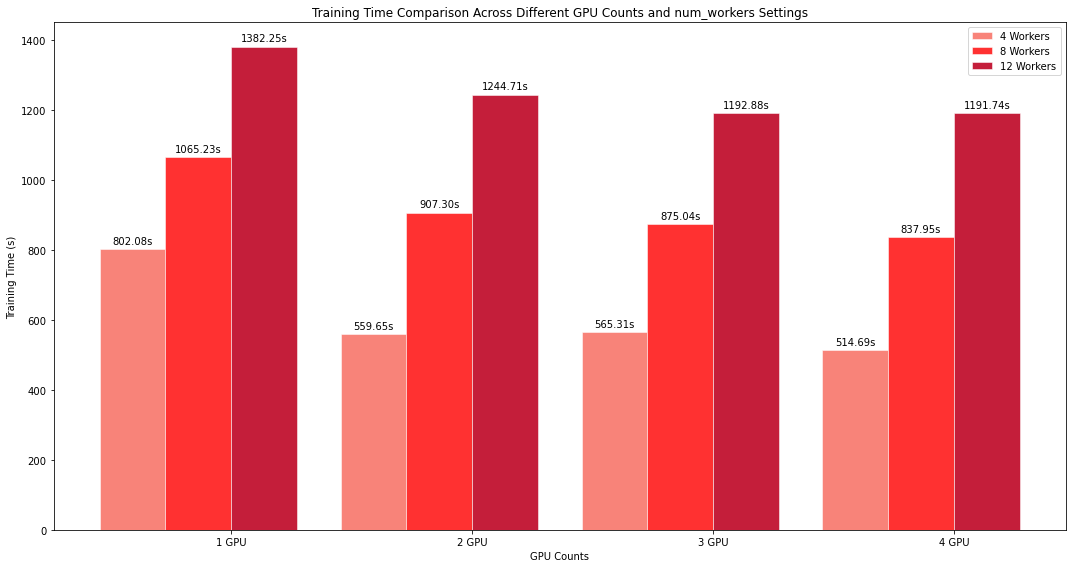

In [53]:
# Define the GPU counts and number of workers you have data for
num_gpus = 4
num_workers_settings = [4, 8, 12]  # Adjust this list based on your available data

# Retrieve the training times
times_dict = get_training_times(num_gpus, num_workers_settings)

# Define the colors
custom_colors = ['#F88379', '#FF3131', '#C41E3A', '#880808']

# Plotting setup
gpu_counts = [f'{i} GPU' for i in range(1, num_gpus + 1)]
n_groups = len(gpu_counts)
bar_width = 0.15
index = np.arange(n_groups) * (bar_width * len(num_workers_settings) + 0.1)  # Increase space between groups

plt.figure(figsize=(15, 8))

for i, num_workers in enumerate(num_workers_settings):
    times = [times_dict[gpu_count][i] for gpu_count in gpu_counts]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=f'{num_workers} Workers', edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}s',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('GPU Counts')
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison Across Different GPU Counts and num_workers Settings')
plt.xticks(index + bar_width * len(num_workers_settings) / 2, gpu_counts)
plt.legend()

plt.tight_layout()
plt.show()

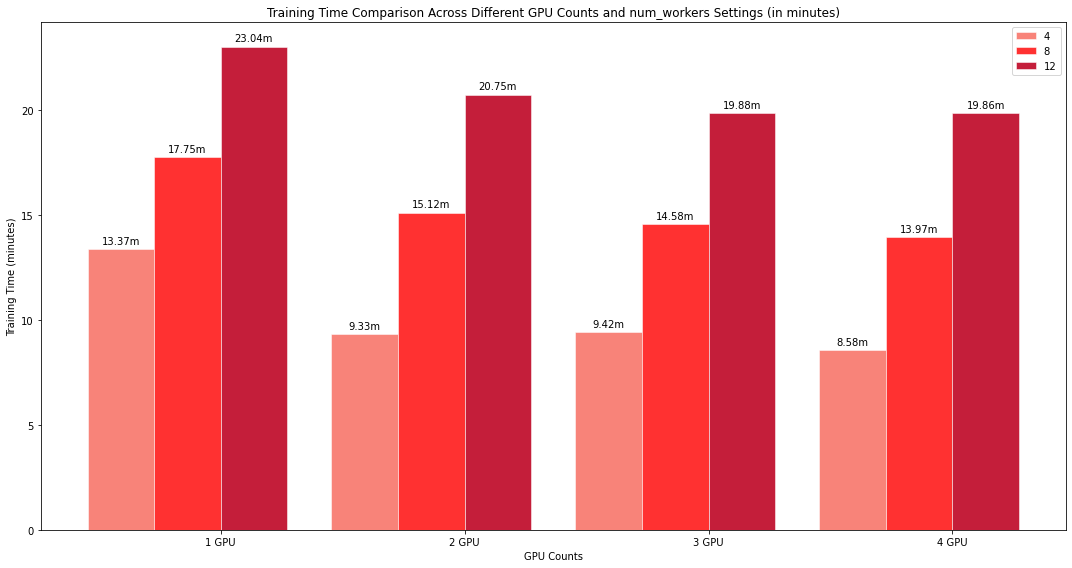

In [54]:
# Convert times to minutes
times_dict_minutes = {gpu: [time / 60 for time in times] for gpu, times in times_dict.items()}

# Plotting in minutes with adjusted bar positions and gaps
plt.figure(figsize=(15, 8))

for i, num_workers in enumerate(num_workers_settings):
    times = [times_dict_minutes[gpu][i] for gpu in gpu_counts]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=num_workers, edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}m',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('GPU Counts')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison Across Different GPU Counts and num_workers Settings (in minutes)')
plt.xticks(index + bar_width * 1.5, gpu_counts)
plt.legend()

plt.tight_layout()
plt.show()

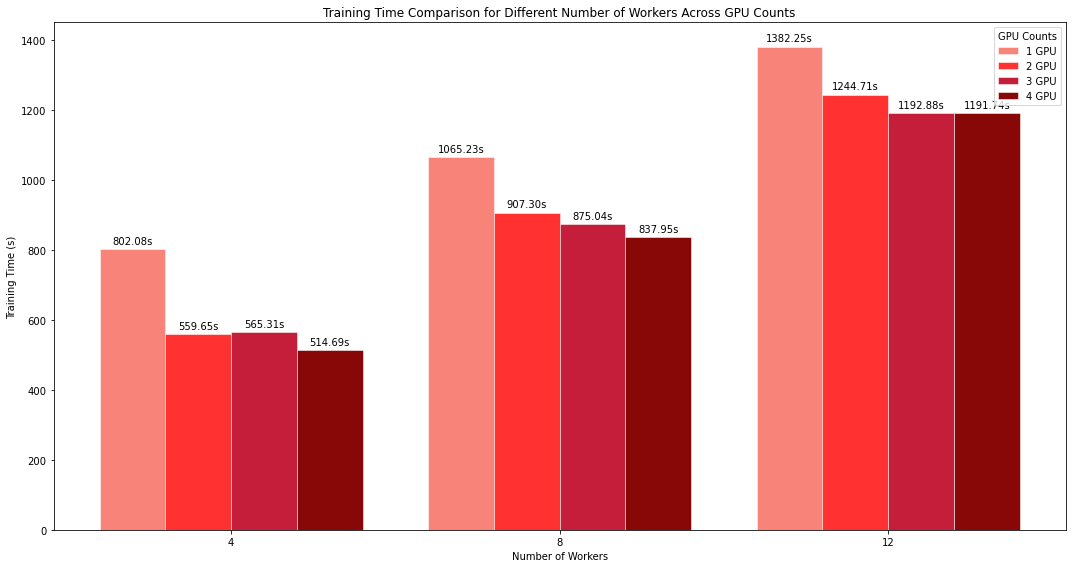

In [55]:
gpu_counts = ['1 GPU', '2 GPU', '3 GPU', '4 GPU']
num_workers_settings = [4, 8, 12]  # Number of worker settings you have

# Ensure each entry in times_dict has the same length as num_workers_settings
for key, times in times_dict.items():
    if len(times) != len(num_workers_settings):
        raise ValueError(f"Data length mismatch in {key}")

# Preparing the plot
n_groups = len(gpu_counts)
bar_width = 0.20
index = np.arange(len(num_workers_settings))

# Plotting in seconds for different number of workers across GPU counts
plt.figure(figsize=(15, 8))

for i, gpu_count in enumerate(gpu_counts):
    times = times_dict[gpu_count]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=f'{gpu_count}', edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}s',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('Number of Workers')
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison for Different Number of Workers Across GPU Counts')
plt.xticks(index + bar_width * 1.5, num_workers_settings)
plt.legend(title='GPU Counts')

plt.tight_layout()
plt.show()

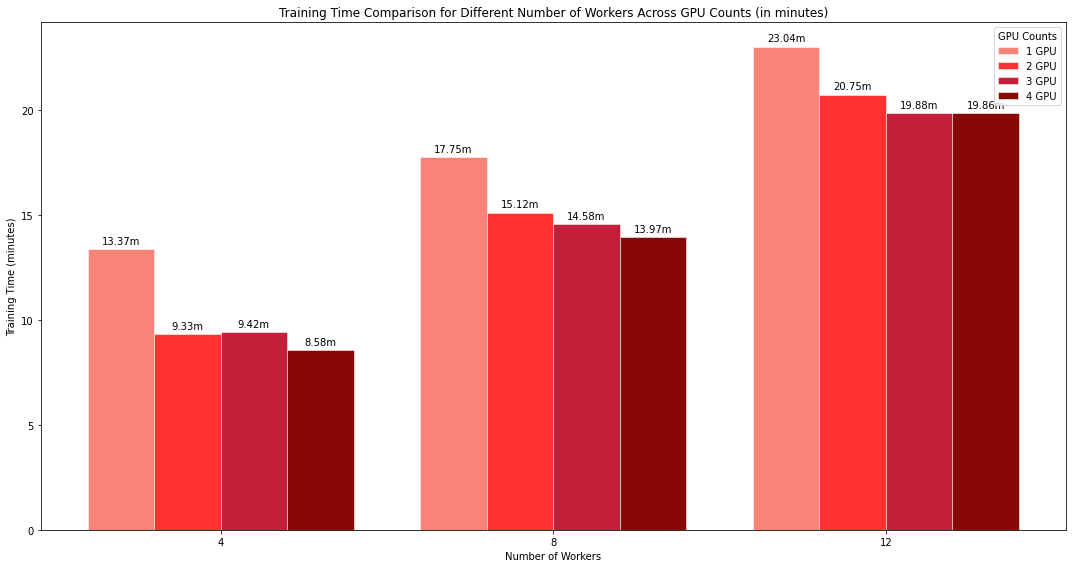

In [56]:
# Convert times to minutes
times_dict_minutes = {gpu: [time / 60 for time in times] for gpu, times in times_dict.items()}

# Plotting in minutes for different number of workers across GPU counts
plt.figure(figsize=(15, 8))

for i, gpu_count in enumerate(gpu_counts):
    times = times_dict_minutes[gpu_count]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=f'{gpu_count}', edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}m',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('Number of Workers')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison for Different Number of Workers Across GPU Counts (in minutes)')
plt.xticks(index + bar_width * 1.5, num_workers_settings)
plt.legend(title='GPU Counts')

plt.tight_layout()
plt.show()

## ----- ResNet50 Model -----

##### This section contains the output logs from the training process of the ResNet50 model showing the progress over epochs, including training and validation loss and accuracy for different GPU configurations.

### 1) ResNet50 Model Across 4 GPU Configurations (4 DataLoader Workers) :

The following scripts are a comprehensive PyTorch-based pipeline designed for training the ResNet50 model on multiple GPUs. It leverages distributed data parallelism across four workers to enhance computational efficiency and reduce training time. The code handles dataset preparation, model training, and evaluation, offering a robust solution for large-scale image classification tasks.
- **ResNet50_4W.py** : Training ResNet50 model across 4 GPU configurations with 4 Worker DataLoaders.
- **ResNet50_8W.py** : Training ResNet50 model across 4 GPU configurations with 8 Worker DataLoaders.
- **ResNet50_12W.py** : Training ResNet50 model across 4 GPU configurations with 12 Worker DataLoaders.

In [57]:
!python resnet50_4W.py

Training with 1 GPU(s)
Epoch 1/5
----------
Train Epoch 1/5: 100%|████████████████████████| 115/115 [02:30<00:00,  1.31s/it]
Train Loss: 0.6798 Acc: 0.7344 Rank: 0
Val Epoch 1/5: 100%|████████████████████████████| 21/21 [00:50<00:00,  2.41s/it]
Val Loss: 0.7802 Acc: 0.7016 Rank: 0
Epoch 2/5
----------
Train Epoch 2/5: 100%|████████████████████████| 115/115 [02:23<00:00,  1.25s/it]
Train Loss: 0.5200 Acc: 0.8030 Rank: 0
Val Epoch 2/5: 100%|████████████████████████████| 21/21 [00:53<00:00,  2.53s/it]
Val Loss: 0.6616 Acc: 0.7450 Rank: 0
Epoch 3/5
----------
Train Epoch 3/5: 100%|████████████████████████| 115/115 [02:32<00:00,  1.33s/it]
Train Loss: 0.4588 Acc: 0.8290 Rank: 0
Val Epoch 3/5: 100%|████████████████████████████| 21/21 [00:45<00:00,  2.16s/it]
Val Loss: 0.6286 Acc: 0.7601 Rank: 0
Epoch 4/5
----------
Train Epoch 4/5: 100%|████████████████████████| 115/115 [02:25<00:00,  1.27s/it]
Train Loss: 0.4056 Acc: 0.8517 Rank: 0
Val Epoch 4/5: 100%|████████████████████████████| 21/21 [00

#### -- Plotting Training Metrics --


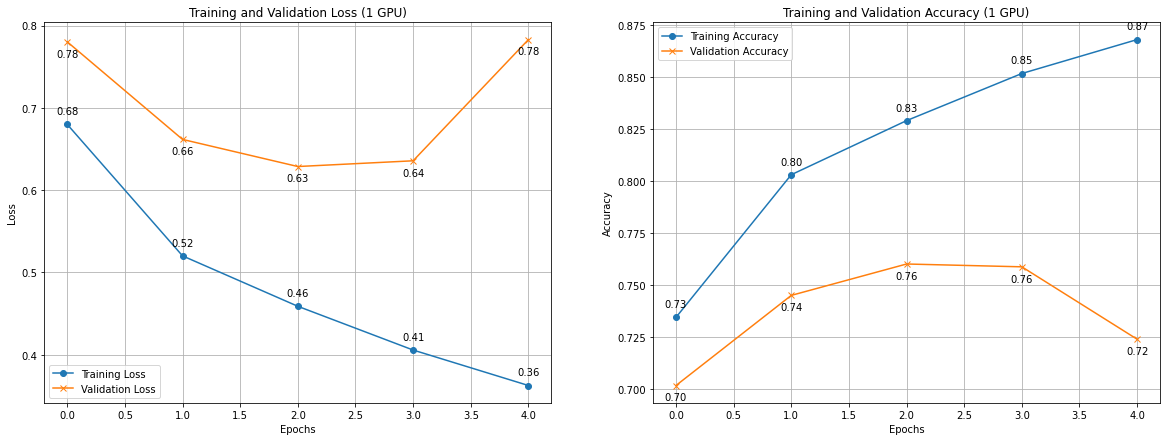

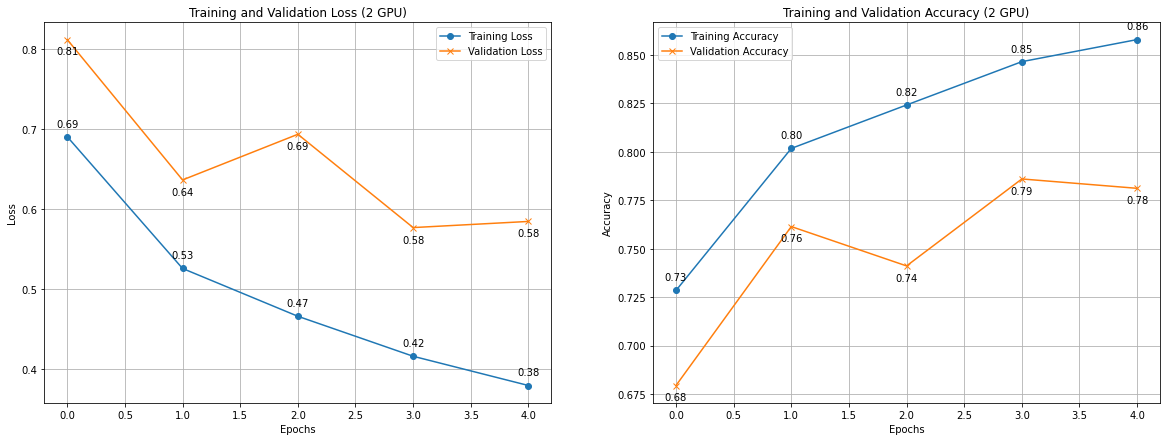

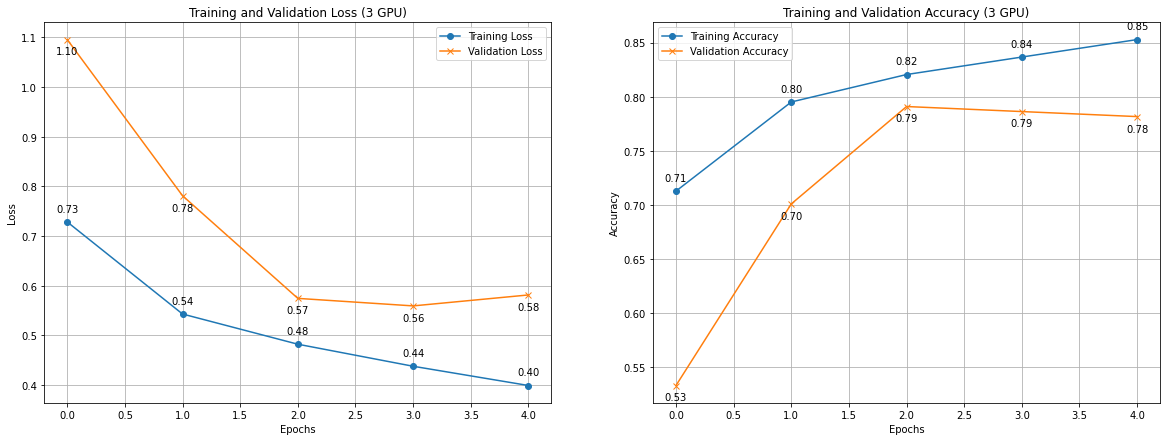

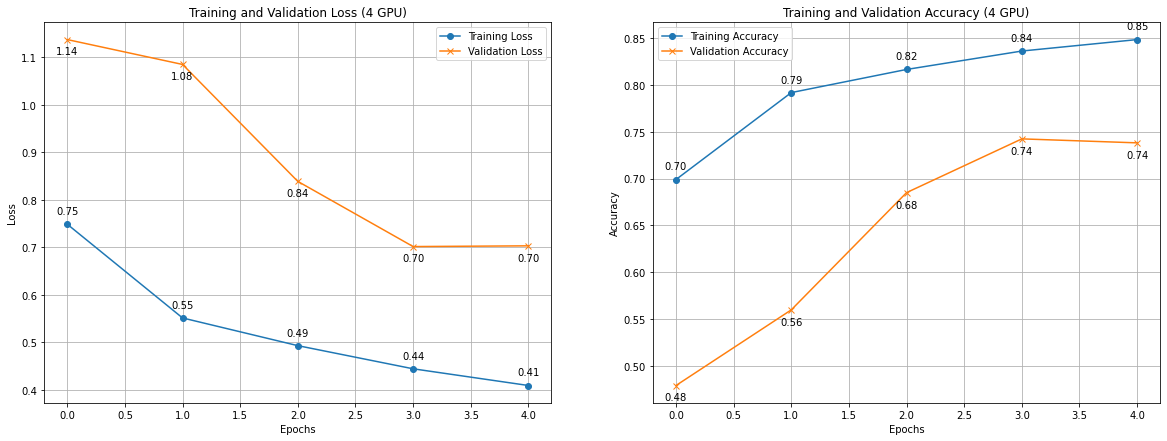

In [58]:
def plot_metrics(num_gpus):
    for i in range(1, num_gpus + 1):
        with open(f'ResNet50_4W/training_metrics_{i}g_4w.json', 'r') as f:
            metrics = json.load(f)

            train_losses = metrics['train_loss']
            val_losses = metrics['val_loss']
            train_accs = metrics['train_acc']
            val_accs = metrics['val_acc']

            plt.figure(figsize=(20, 7))

            # Plotting Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='x')
            plt.title(f'Training and Validation Loss ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Loss plot
            for j, (tl, vl) in enumerate(zip(train_losses, val_losses)):
                plt.annotate(f"{tl:.2f}", (j, tl), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{vl:.2f}", (j, vl), textcoords="offset points", xytext=(0,-15), ha='center')

            # Plotting Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Training Accuracy', marker='o')
            plt.plot(val_accs, label='Validation Accuracy', marker='x')
            plt.title(f'Training and Validation Accuracy ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Accuracy plot
            for j, (ta, va) in enumerate(zip(train_accs, val_accs)):
                plt.annotate(f"{ta:.2f}", (j, ta), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{va:.2f}", (j, va), textcoords="offset points", xytext=(0,-15), ha='center')

            plt.show()

# Call the function after running the Python script
plot_metrics(4)

#### -- Training Time Comparison --


In [59]:
def get_training_times(num_gpus):
    times = []
    for i in range(1, num_gpus + 1):
        with open(f'ResNet50_4W/training_metrics_{i}g_4w.json', 'r') as f:
            metrics = json.load(f)
            # Assuming 'time' is a list and you want the first element
            times.append(metrics['time'][0])
    return times

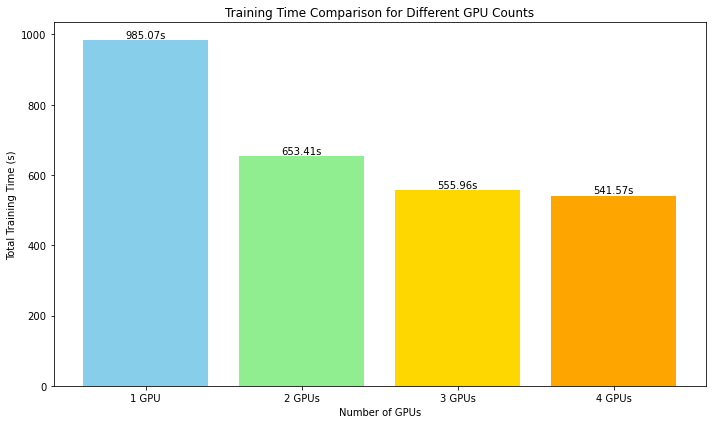

In [60]:
max_gpus = 4  # Define the maximum number of GPUs you've used for training
actual_training_times_1worker = get_training_times(max_gpus)
gpu_counts = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']

# Plotting the time comparison with actual times
plt.figure(figsize=(10, 6))
plt.bar(gpu_counts, actual_training_times_1worker, color=['skyblue', 'lightgreen', 'gold', 'orange'])

# Annotating the training times above each bar
for i, time in enumerate(actual_training_times_1worker):
    plt.text(i, time, f'{time:.2f}s', ha='center', va='bottom')

plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (s)')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### -- Speedup and Efficiency Analysis --


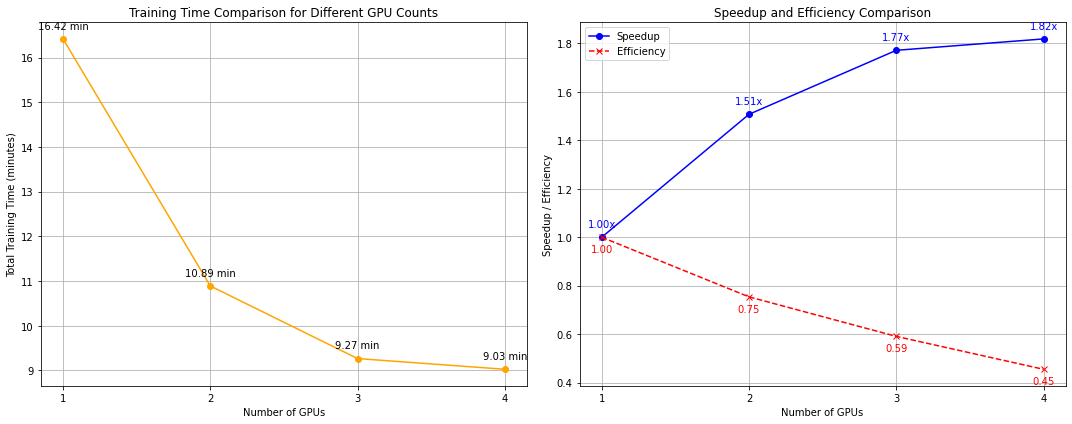

In [61]:
max_gpus = 4  # or the maximum number of GPUs you have data for
total_times = get_training_times(max_gpus)

# Convert times to minutes for plotting
times_in_minutes = [time / 60 for time in total_times]

# GPU counts
gpu_counts = list(range(1, max_gpus + 1))

# Calculate speedup based on the first entry as baseline
baseline_time = times_in_minutes[0]
speedups = [baseline_time / time for time in times_in_minutes]

# Calculate efficiency
efficiencies = [speedup / gpu for speedup, gpu in zip(speedups, gpu_counts)]

# Plotting the time comparison
plt.figure(figsize=(15, 6))

# Plotting Training Time
plt.subplot(1, 2, 1)
plt.plot(gpu_counts, times_in_minutes, marker='o', linestyle='-', color='orange')
plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (minutes)')
plt.xticks(gpu_counts)
plt.grid(True)

# Annotate training times
for i, time in enumerate(times_in_minutes):
    plt.annotate(f"{time:.2f} min", (gpu_counts[i], time), textcoords="offset points", xytext=(0,10), ha='center')

# Plotting Speedup and Efficiency
plt.subplot(1, 2, 2)
plt.plot(gpu_counts, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
plt.plot(gpu_counts, efficiencies, marker='x', linestyle='--', color='red', label='Efficiency')
plt.title('Speedup and Efficiency Comparison')
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup / Efficiency')
plt.xticks(gpu_counts)
plt.grid(True)
plt.legend()

# Annotate speedup and efficiency
for i, (s, e) in enumerate(zip(speedups, efficiencies)):
    plt.annotate(f"{s:.2f}x", (gpu_counts[i], s), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f"{e:.2f}", (gpu_counts[i], e), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()


#### -- Model Performance Evaluation --


              precision    recall  f1-score   support

           0       0.72      0.94      0.82       242
           1       0.90      0.91      0.91       242
           2       0.95      0.64      0.76       242
           3       0.96      0.97      0.96       242

    accuracy                           0.87       968
   macro avg       0.88      0.87      0.86       968
weighted avg       0.88      0.87      0.86       968



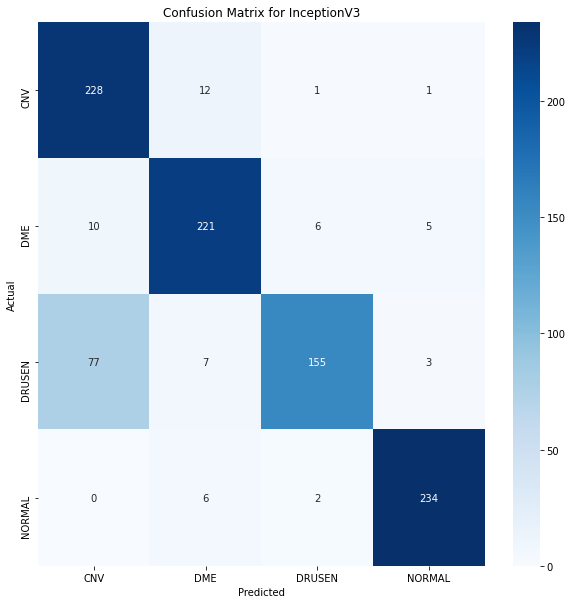

In [62]:
# Load predictions and labels
with open('ResNet50_4W/model_predictions_4w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])

# Print classification report
print(classification_report(all_labels, all_preds))

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Plot confusion matrix
# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

### 2) ResNet50 Model Across 4 GPU Configurations (8 DataLoader Workers) :

The following script is a comprehensive PyTorch-based pipeline designed for training the ResNet50 model on multiple GPUs. It leverages distributed data parallelism across eight workers to enhance computational efficiency and reduce training time. The code handles dataset preparation, model training, and evaluation, offering a robust solution for large-scale image classification tasks. This is almost the same script as before, except we use 8 workers here.

In [63]:
!python resnet50_8W.py

Training with 1 GPU(s)
Epoch 1/5
----------
Train Epoch 1/5: 100%|████████████████████████| 115/115 [03:07<00:00,  1.63s/it]
Train Loss: 0.6787 Acc: 0.7317 Rank: 0
Val Epoch 1/5: 100%|████████████████████████████| 21/21 [01:23<00:00,  4.00s/it]
Val Loss: 0.7569 Acc: 0.7142 Rank: 0
Epoch 2/5
----------
Train Epoch 2/5: 100%|████████████████████████| 115/115 [03:00<00:00,  1.57s/it]
Train Loss: 0.5183 Acc: 0.8019 Rank: 0
Val Epoch 2/5: 100%|████████████████████████████| 21/21 [01:14<00:00,  3.53s/it]
Val Loss: 0.6081 Acc: 0.7695 Rank: 0
Epoch 3/5
----------
Train Epoch 3/5: 100%|████████████████████████| 115/115 [03:01<00:00,  1.58s/it]
Train Loss: 0.4535 Acc: 0.8290 Rank: 0
Val Epoch 3/5: 100%|████████████████████████████| 21/21 [01:23<00:00,  4.00s/it]
Val Loss: 0.6839 Acc: 0.7527 Rank: 0
Epoch 4/5
----------
Train Epoch 4/5: 100%|████████████████████████| 115/115 [02:54<00:00,  1.52s/it]
Train Loss: 0.4073 Acc: 0.8476 Rank: 0
Val Epoch 4/5: 100%|████████████████████████████| 21/21 [01

#### -- Plotting Training Metrics --


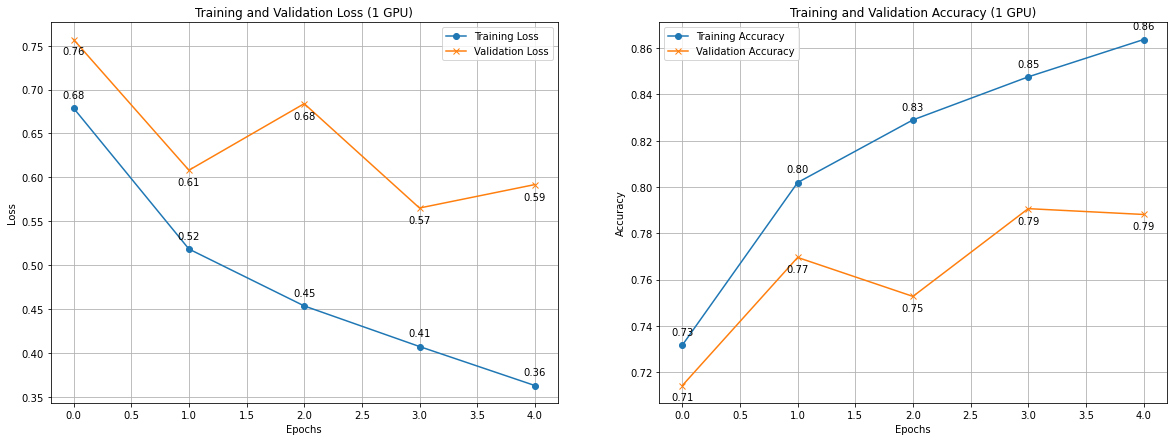

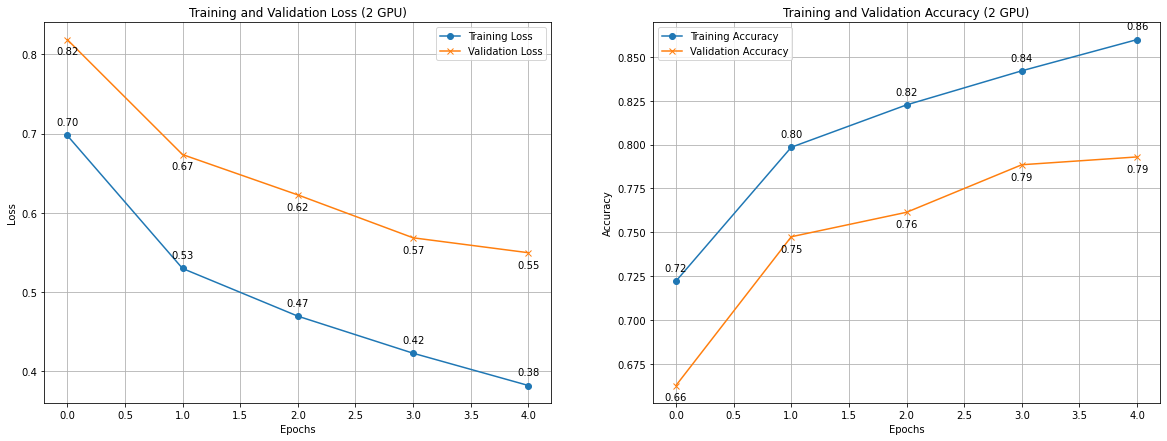

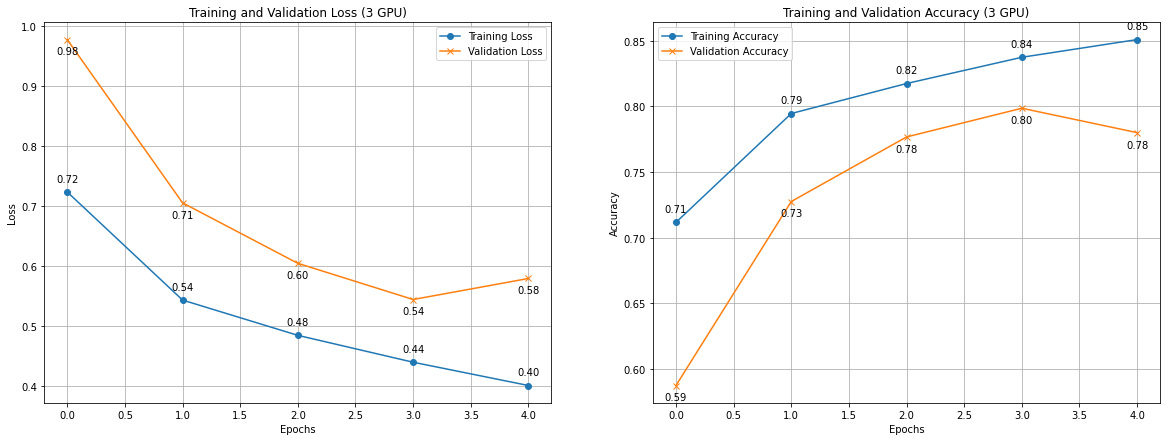

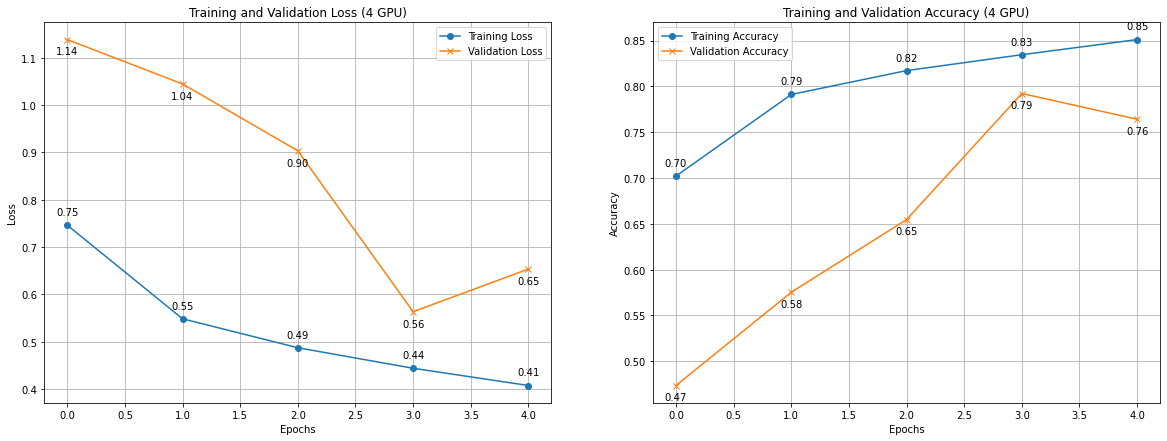

In [64]:
def plot_metrics(num_gpus):
    for i in range(1, num_gpus + 1):
        with open(f'ResNet50_8W/training_metrics_{i}g_8w.json', 'r') as f:
            metrics = json.load(f)

            train_losses = metrics['train_loss']
            val_losses = metrics['val_loss']
            train_accs = metrics['train_acc']
            val_accs = metrics['val_acc']

            plt.figure(figsize=(20, 7))

            # Plotting Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='x')
            plt.title(f'Training and Validation Loss ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Loss plot
            for j, (tl, vl) in enumerate(zip(train_losses, val_losses)):
                plt.annotate(f"{tl:.2f}", (j, tl), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{vl:.2f}", (j, vl), textcoords="offset points", xytext=(0,-15), ha='center')

            # Plotting Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Training Accuracy', marker='o')
            plt.plot(val_accs, label='Validation Accuracy', marker='x')
            plt.title(f'Training and Validation Accuracy ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Accuracy plot
            for j, (ta, va) in enumerate(zip(train_accs, val_accs)):
                plt.annotate(f"{ta:.2f}", (j, ta), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{va:.2f}", (j, va), textcoords="offset points", xytext=(0,-15), ha='center')

            plt.show()

# Call the function after running the Python script
plot_metrics(4)

#### -- Training Time Comparison --


In [65]:
def get_training_times(num_gpus):
    times = []
    for i in range(1, num_gpus + 1):
        with open(f'ResNet50_8W/training_metrics_{i}g_8w.json', 'r') as f:
            metrics = json.load(f)
            # Assuming 'time' is a list and you want the first element
            times.append(metrics['time'][0])
    return times

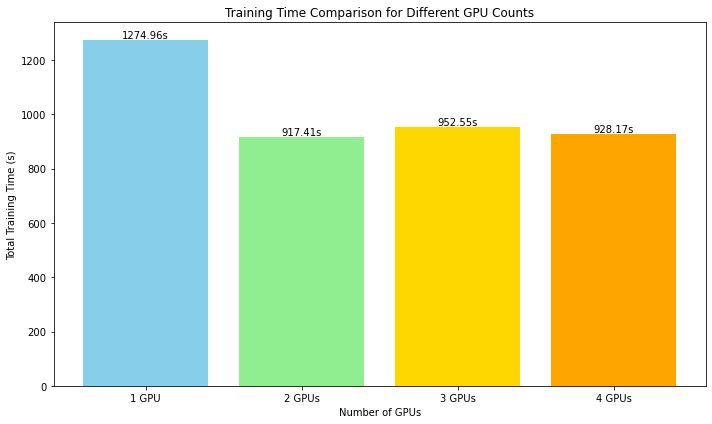

In [66]:
max_gpus = 4  # Define the maximum number of GPUs you've used for training
actual_training_times_1worker = get_training_times(max_gpus)
gpu_counts = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']

# Plotting the time comparison with actual times
plt.figure(figsize=(10, 6))
plt.bar(gpu_counts, actual_training_times_1worker, color=['skyblue', 'lightgreen', 'gold', 'orange'])

# Annotating the training times above each bar
for i, time in enumerate(actual_training_times_1worker):
    plt.text(i, time, f'{time:.2f}s', ha='center', va='bottom')

plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (s)')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### -- Speedup and Efficiency Analysis --


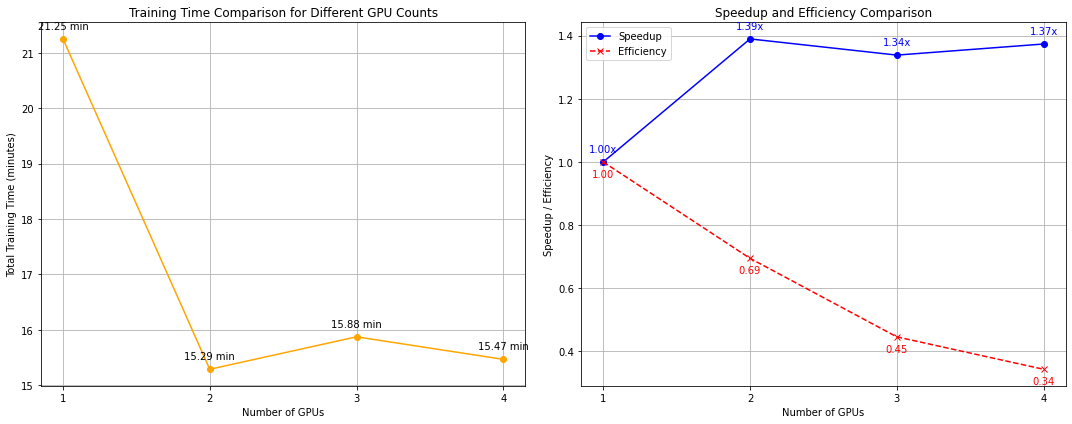

In [67]:
max_gpus = 4  # or the maximum number of GPUs you have data for
total_times = get_training_times(max_gpus)

# Convert times to minutes for plotting
times_in_minutes = [time / 60 for time in total_times]

# GPU counts
gpu_counts = list(range(1, max_gpus + 1))

# Calculate speedup based on the first entry as baseline
baseline_time = times_in_minutes[0]
speedups = [baseline_time / time for time in times_in_minutes]

# Calculate efficiency
efficiencies = [speedup / gpu for speedup, gpu in zip(speedups, gpu_counts)]

# Plotting the time comparison
plt.figure(figsize=(15, 6))

# Plotting Training Time
plt.subplot(1, 2, 1)
plt.plot(gpu_counts, times_in_minutes, marker='o', linestyle='-', color='orange')
plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (minutes)')
plt.xticks(gpu_counts)
plt.grid(True)

# Annotate training times
for i, time in enumerate(times_in_minutes):
    plt.annotate(f"{time:.2f} min", (gpu_counts[i], time), textcoords="offset points", xytext=(0,10), ha='center')

# Plotting Speedup and Efficiency
plt.subplot(1, 2, 2)
plt.plot(gpu_counts, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
plt.plot(gpu_counts, efficiencies, marker='x', linestyle='--', color='red', label='Efficiency')
plt.title('Speedup and Efficiency Comparison')
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup / Efficiency')
plt.xticks(gpu_counts)
plt.grid(True)
plt.legend()

# Annotate speedup and efficiency
for i, (s, e) in enumerate(zip(speedups, efficiencies)):
    plt.annotate(f"{s:.2f}x", (gpu_counts[i], s), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f"{e:.2f}", (gpu_counts[i], e), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()


#### -- Model Performance Evaluation --


              precision    recall  f1-score   support

           0       0.80      0.96      0.87       242
           1       0.94      0.91      0.92       242
           2       0.96      0.75      0.84       242
           3       0.93      0.98      0.95       242

    accuracy                           0.90       968
   macro avg       0.91      0.90      0.90       968
weighted avg       0.91      0.90      0.90       968



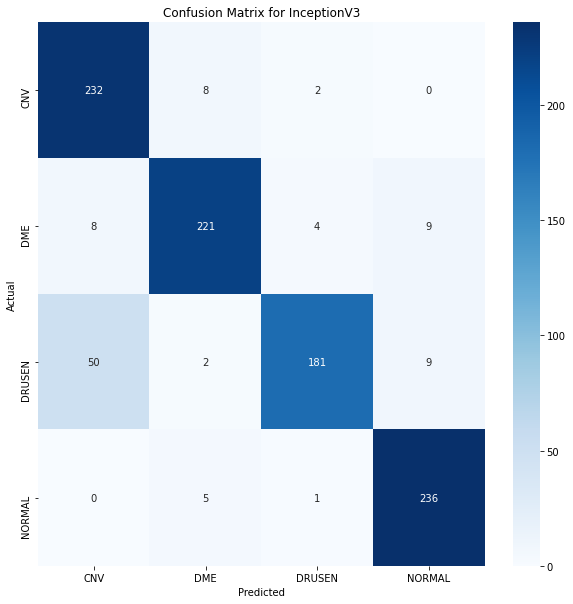

In [68]:
# Load predictions and labels
with open('ResNet50_8W/model_predictions_8w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])

# Print classification report
print(classification_report(all_labels, all_preds))

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Plot confusion matrix
# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

### 3) ResNet50 Model Across 4 GPU Configurations (12 DataLoader Workers) :

The following script is a comprehensive PyTorch-based pipeline designed for training the ResNet50 model on multiple GPUs. It leverages distributed data parallelism across twelve workers to enhance computational efficiency and reduce training time. The code handles dataset preparation, model training, and evaluation, offering a robust solution for large-scale image classification tasks. This is almost the same script as before, except we use 12 workers here.

In [69]:
!python resnet50_12W.py

Training with 1 GPU(s)
Epoch 1/5
----------
Train Epoch 1/5: 100%|████████████████████████| 115/115 [03:18<00:00,  1.72s/it]
Train Loss: 0.6799 Acc: 0.7344 Rank: 0
Val Epoch 1/5: 100%|████████████████████████████| 21/21 [01:50<00:00,  5.27s/it]
Val Loss: 0.7242 Acc: 0.7264 Rank: 0
Epoch 2/5
----------
Train Epoch 2/5: 100%|████████████████████████| 115/115 [03:44<00:00,  1.95s/it]
Train Loss: 0.5227 Acc: 0.8042 Rank: 0
Val Epoch 2/5: 100%|████████████████████████████| 21/21 [02:01<00:00,  5.81s/it]
Val Loss: 0.6133 Acc: 0.7659 Rank: 0
Epoch 3/5
----------
Train Epoch 3/5: 100%|████████████████████████| 115/115 [03:27<00:00,  1.80s/it]
Train Loss: 0.4576 Acc: 0.8275 Rank: 0
Val Epoch 3/5: 100%|████████████████████████████| 21/21 [01:41<00:00,  4.84s/it]
Val Loss: 0.6335 Acc: 0.7647 Rank: 0
Epoch 4/5
----------
Train Epoch 4/5: 100%|████████████████████████| 115/115 [03:30<00:00,  1.83s/it]
Train Loss: 0.4069 Acc: 0.8488 Rank: 0
Val Epoch 4/5: 100%|████████████████████████████| 21/21 [01

#### -- Plotting Training Metrics --


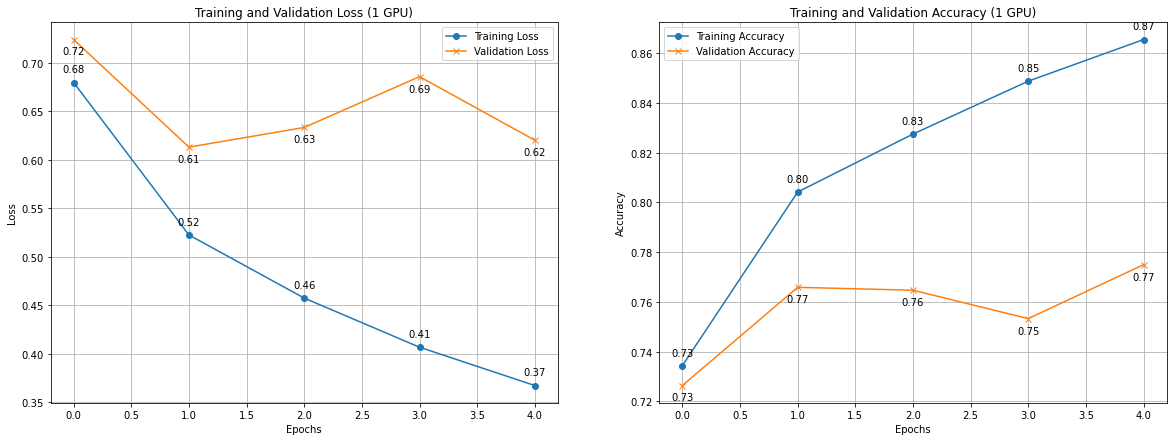

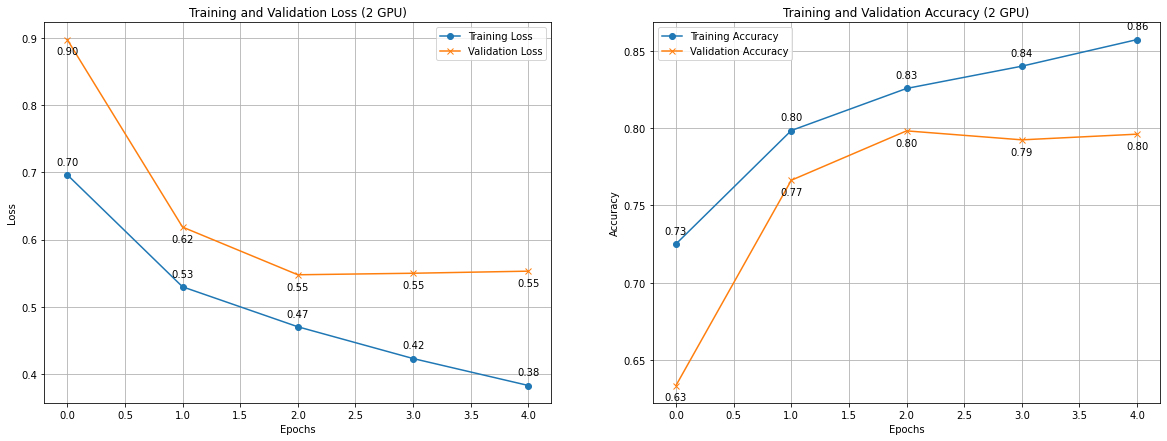

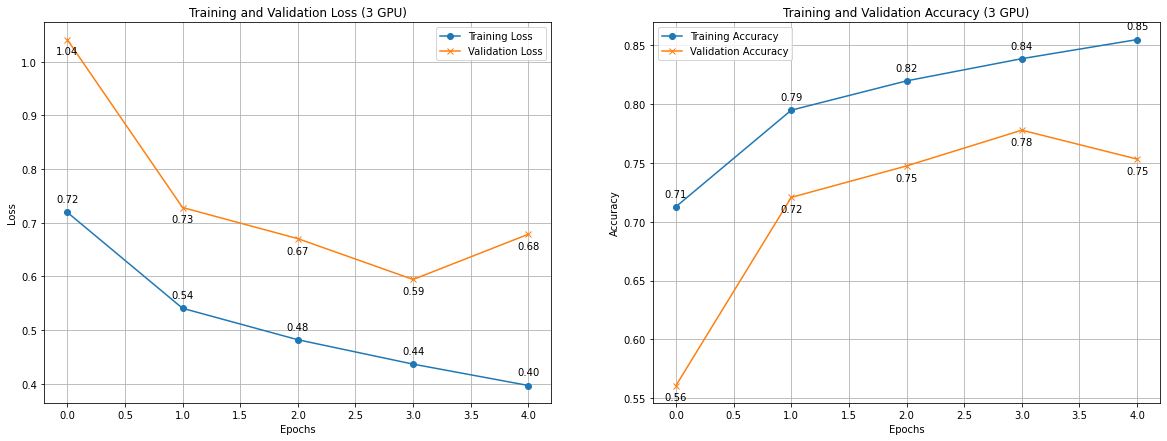

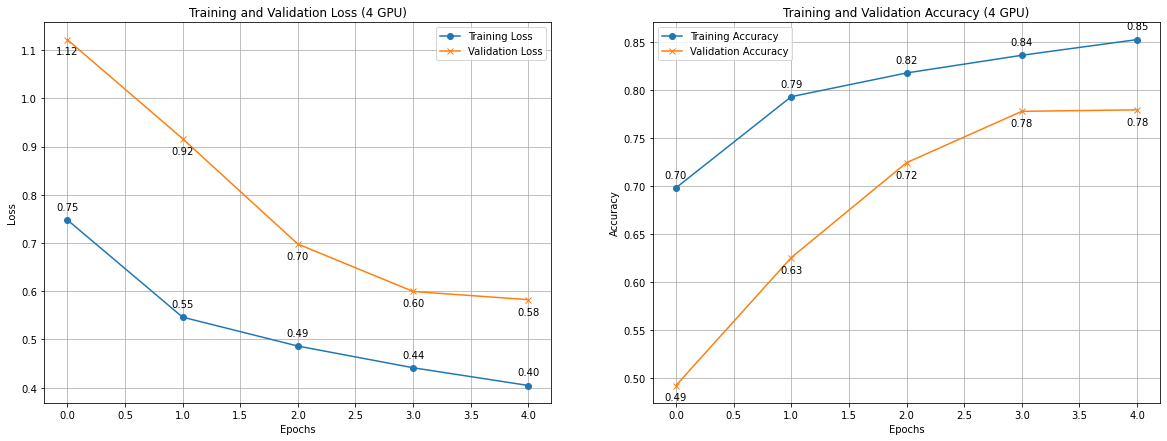

In [70]:
def plot_metrics(num_gpus):
    for i in range(1, num_gpus + 1):
        with open(f'ResNet50_12W/training_metrics_{i}g_12w.json', 'r') as f:
            metrics = json.load(f)

            train_losses = metrics['train_loss']
            val_losses = metrics['val_loss']
            train_accs = metrics['train_acc']
            val_accs = metrics['val_acc']

            plt.figure(figsize=(20, 7))

            # Plotting Training and Validation Loss
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Training Loss', marker='o')
            plt.plot(val_losses, label='Validation Loss', marker='x')
            plt.title(f'Training and Validation Loss ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Loss plot
            for j, (tl, vl) in enumerate(zip(train_losses, val_losses)):
                plt.annotate(f"{tl:.2f}", (j, tl), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{vl:.2f}", (j, vl), textcoords="offset points", xytext=(0,-15), ha='center')

            # Plotting Training and Validation Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_accs, label='Training Accuracy', marker='o')
            plt.plot(val_accs, label='Validation Accuracy', marker='x')
            plt.title(f'Training and Validation Accuracy ({i} GPU)')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Annotating the values on the Accuracy plot
            for j, (ta, va) in enumerate(zip(train_accs, val_accs)):
                plt.annotate(f"{ta:.2f}", (j, ta), textcoords="offset points", xytext=(0,10), ha='center')
                plt.annotate(f"{va:.2f}", (j, va), textcoords="offset points", xytext=(0,-15), ha='center')

            plt.show()

# Call the function after running the Python script
plot_metrics(4)

#### -- Training Time Comparison --


In [71]:
def get_training_times(num_gpus):
    times = []
    for i in range(1, num_gpus + 1):
        with open(f'ResNet50_12W/training_metrics_{i}g_12w.json', 'r') as f:
            metrics = json.load(f)
            # Assuming 'time' is a list and you want the first element
            times.append(metrics['time'][0])
    return times

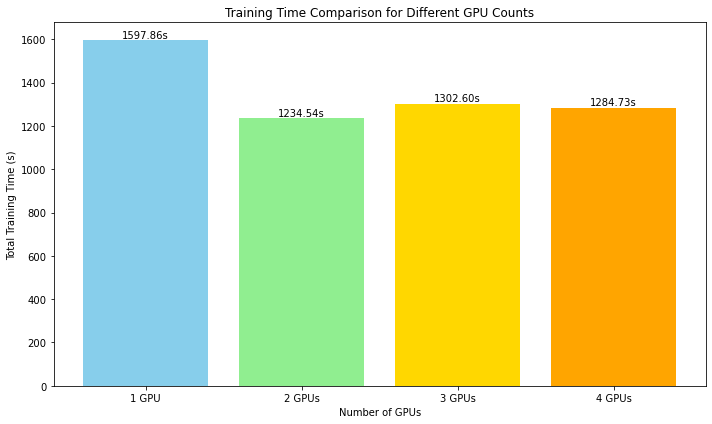

In [72]:
max_gpus = 4  # Define the maximum number of GPUs you've used for training
actual_training_times_1worker = get_training_times(max_gpus)
gpu_counts = ['1 GPU', '2 GPUs', '3 GPUs', '4 GPUs']

# Plotting the time comparison with actual times
plt.figure(figsize=(10, 6))
plt.bar(gpu_counts, actual_training_times_1worker, color=['skyblue', 'lightgreen', 'gold', 'orange'])

# Annotating the training times above each bar
for i, time in enumerate(actual_training_times_1worker):
    plt.text(i, time, f'{time:.2f}s', ha='center', va='bottom')

plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (s)')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()


#### -- Speedup and Efficiency Analysis --


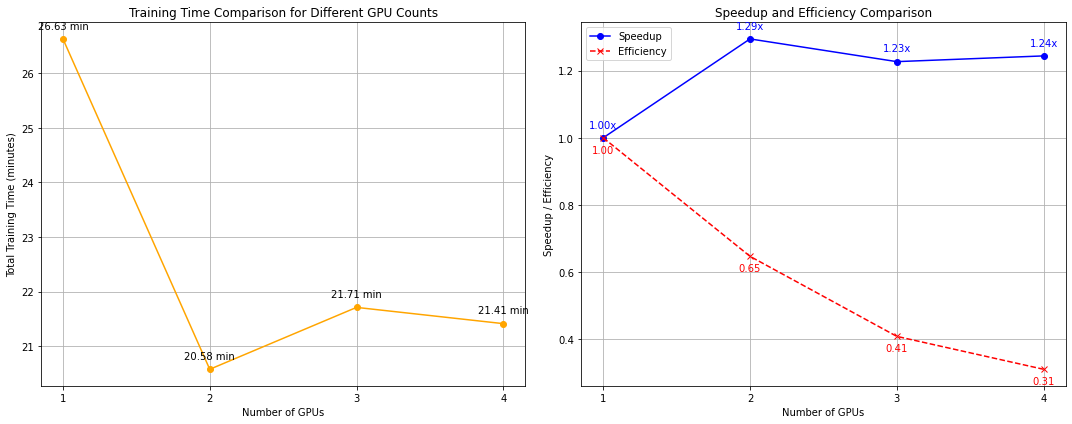

In [73]:
max_gpus = 4  # or the maximum number of GPUs you have data for
total_times = get_training_times(max_gpus)

# Convert times to minutes for plotting
times_in_minutes = [time / 60 for time in total_times]

# GPU counts
gpu_counts = list(range(1, max_gpus + 1))

# Calculate speedup based on the first entry as baseline
baseline_time = times_in_minutes[0]
speedups = [baseline_time / time for time in times_in_minutes]

# Calculate efficiency
efficiencies = [speedup / gpu for speedup, gpu in zip(speedups, gpu_counts)]

# Plotting the time comparison
plt.figure(figsize=(15, 6))

# Plotting Training Time
plt.subplot(1, 2, 1)
plt.plot(gpu_counts, times_in_minutes, marker='o', linestyle='-', color='orange')
plt.title('Training Time Comparison for Different GPU Counts')
plt.xlabel('Number of GPUs')
plt.ylabel('Total Training Time (minutes)')
plt.xticks(gpu_counts)
plt.grid(True)

# Annotate training times
for i, time in enumerate(times_in_minutes):
    plt.annotate(f"{time:.2f} min", (gpu_counts[i], time), textcoords="offset points", xytext=(0,10), ha='center')

# Plotting Speedup and Efficiency
plt.subplot(1, 2, 2)
plt.plot(gpu_counts, speedups, marker='o', linestyle='-', color='blue', label='Speedup')
plt.plot(gpu_counts, efficiencies, marker='x', linestyle='--', color='red', label='Efficiency')
plt.title('Speedup and Efficiency Comparison')
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup / Efficiency')
plt.xticks(gpu_counts)
plt.grid(True)
plt.legend()

# Annotate speedup and efficiency
for i, (s, e) in enumerate(zip(speedups, efficiencies)):
    plt.annotate(f"{s:.2f}x", (gpu_counts[i], s), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    plt.annotate(f"{e:.2f}", (gpu_counts[i], e), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.tight_layout()
plt.show()


#### -- Model Performance Evaluation --


              precision    recall  f1-score   support

           0       0.71      0.98      0.83       242
           1       0.97      0.87      0.92       242
           2       0.96      0.64      0.77       242
           3       0.93      0.99      0.96       242

    accuracy                           0.87       968
   macro avg       0.89      0.87      0.87       968
weighted avg       0.89      0.87      0.87       968



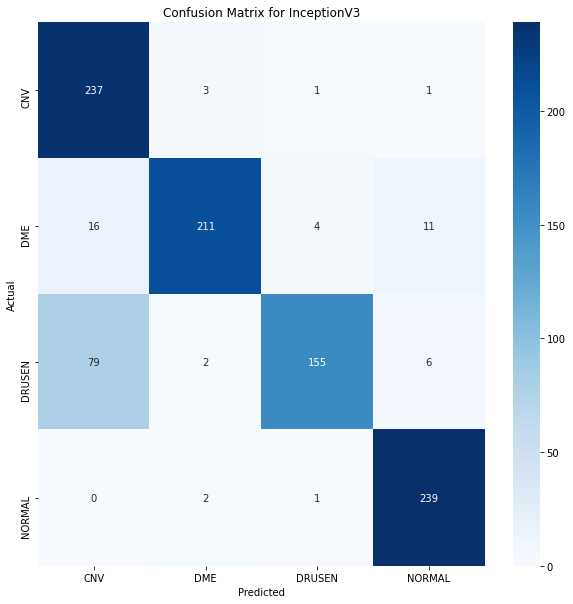

In [74]:
# Load predictions and labels
with open('ResNet50_12W/model_predictions_12w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])

# Print classification report
print(classification_report(all_labels, all_preds))

class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Plot confusion matrix
# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names, model_name):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

## Comparison of Multiple GPUs Training Time Across Different Worker Settings (ResNet50)

In [75]:
def get_training_times(num_gpus, num_workers_settings):
    times_dict = {}
    for gpu_count in range(1, num_gpus + 1):
        times = []
        for workers in num_workers_settings:
            filename = f'ResNet50_{workers}W/training_metrics_{gpu_count}g_{workers}w.json'
            with open(filename, 'r') as f:
                metrics = json.load(f)
                times.append(metrics['time'][0])  # Assuming 'time' is the total training time
        times_dict[f'{gpu_count} GPU'] = times
    return times_dict

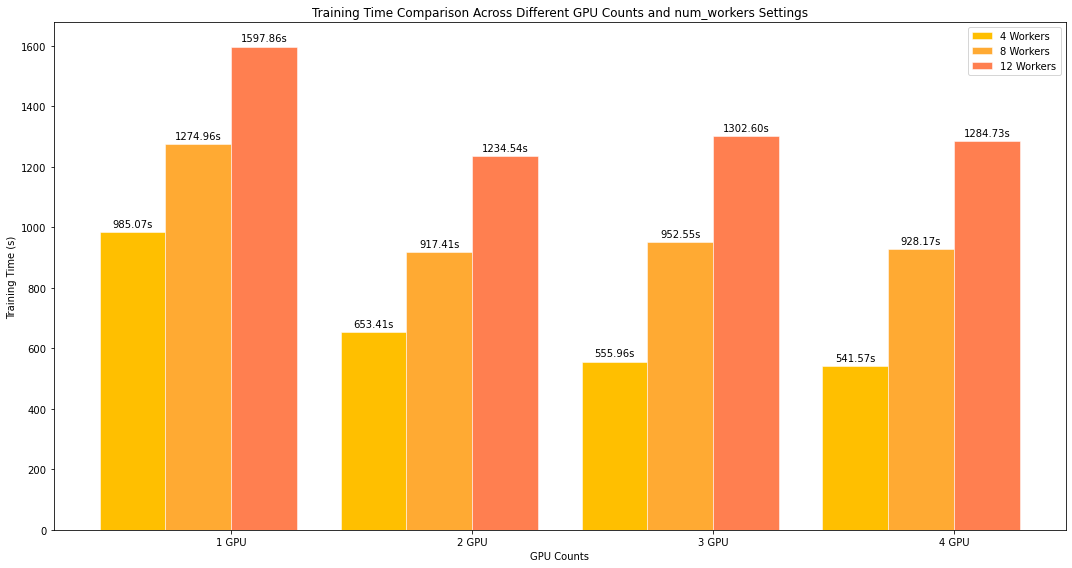

In [76]:
# Define the GPU counts and number of workers you have data for
num_gpus = 4
num_workers_settings = [4, 8, 12]  # Adjust this list based on your available data

# Retrieve the training times
times_dict = get_training_times(num_gpus, num_workers_settings)

# Define the colors
custom_colors = ['#FFBF00', '#FFAA33', '#FF7F50', '#FF5F1F']

# Plotting setup
gpu_counts = [f'{i} GPU' for i in range(1, num_gpus + 1)]
n_groups = len(gpu_counts)
bar_width = 0.15
index = np.arange(n_groups) * (bar_width * len(num_workers_settings) + 0.1)  # Increase space between groups

plt.figure(figsize=(15, 8))

for i, num_workers in enumerate(num_workers_settings):
    times = [times_dict[gpu_count][i] for gpu_count in gpu_counts]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=f'{num_workers} Workers', edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}s',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('GPU Counts')
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison Across Different GPU Counts and num_workers Settings')
plt.xticks(index + bar_width * len(num_workers_settings) / 2, gpu_counts)
plt.legend()

plt.tight_layout()
plt.show()

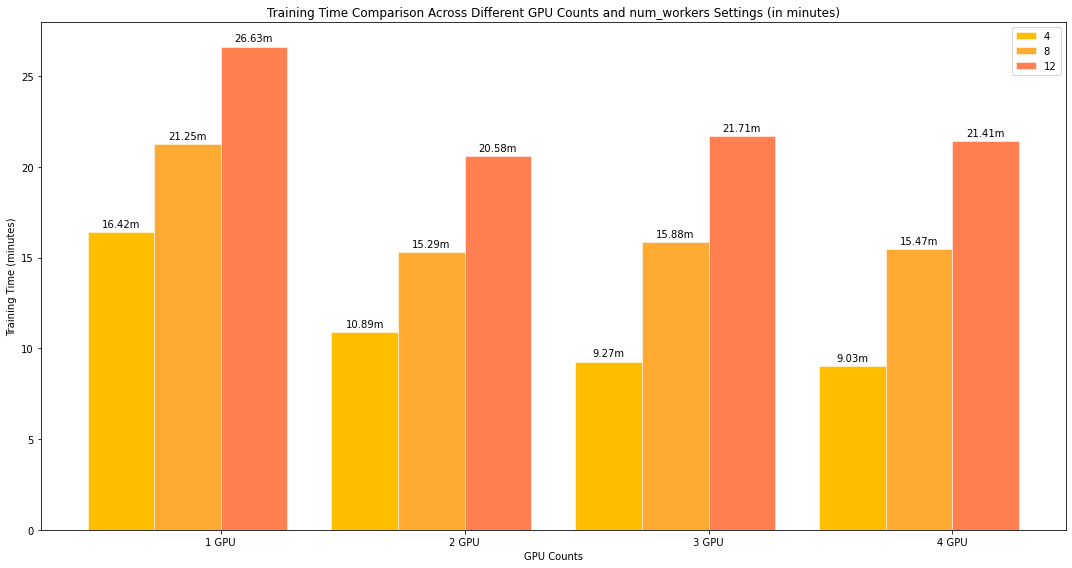

In [77]:
# Convert times to minutes
times_dict_minutes = {gpu: [time / 60 for time in times] for gpu, times in times_dict.items()}

# Plotting in minutes with adjusted bar positions and gaps
plt.figure(figsize=(15, 8))

for i, num_workers in enumerate(num_workers_settings):
    times = [times_dict_minutes[gpu][i] for gpu in gpu_counts]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=num_workers, edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}m',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('GPU Counts')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison Across Different GPU Counts and num_workers Settings (in minutes)')
plt.xticks(index + bar_width * 1.5, gpu_counts)
plt.legend()

plt.tight_layout()
plt.show()

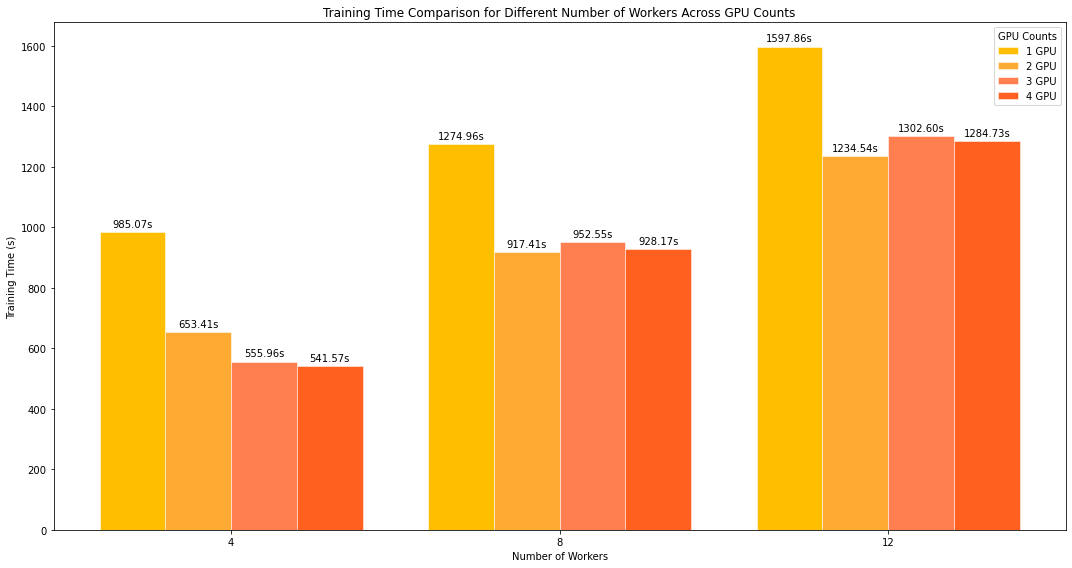

In [78]:
gpu_counts = ['1 GPU', '2 GPU', '3 GPU', '4 GPU']
num_workers_settings = [4, 8, 12]  # Number of worker settings you have

# Ensure each entry in times_dict has the same length as num_workers_settings
for key, times in times_dict.items():
    if len(times) != len(num_workers_settings):
        raise ValueError(f"Data length mismatch in {key}")

# Preparing the plot
n_groups = len(gpu_counts)
bar_width = 0.20
index = np.arange(len(num_workers_settings))

# Plotting in seconds for different number of workers across GPU counts
plt.figure(figsize=(15, 8))

for i, gpu_count in enumerate(gpu_counts):
    times = times_dict[gpu_count]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=f'{gpu_count}', edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}s',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('Number of Workers')
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison for Different Number of Workers Across GPU Counts')
plt.xticks(index + bar_width * 1.5, num_workers_settings)
plt.legend(title='GPU Counts')

plt.tight_layout()
plt.show()

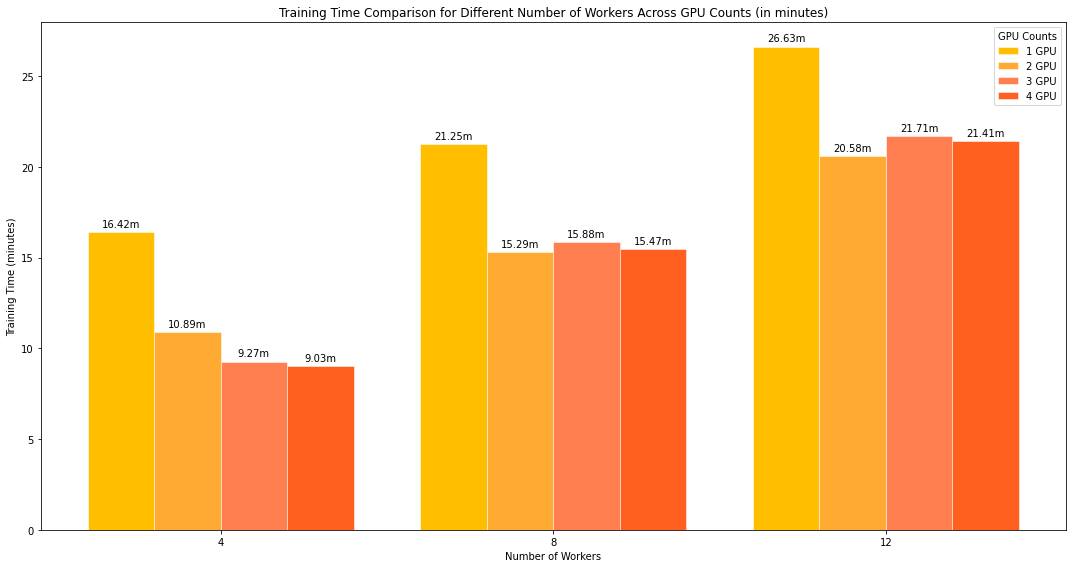

In [79]:
# Convert times to minutes
times_dict_minutes = {gpu: [time / 60 for time in times] for gpu, times in times_dict.items()}

# Plotting in minutes for different number of workers across GPU counts
plt.figure(figsize=(15, 8))

for i, gpu_count in enumerate(gpu_counts):
    times = times_dict_minutes[gpu_count]
    bars = plt.bar(index + i * bar_width, times, bar_width, label=f'{gpu_count}', edgecolor='white', linewidth=0.5, color=custom_colors[i])
    
    # Adding annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}m',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.xlabel('Number of Workers')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time Comparison for Different Number of Workers Across GPU Counts (in minutes)')
plt.xticks(index + bar_width * 1.5, num_workers_settings)
plt.legend(title='GPU Counts')

plt.tight_layout()
plt.show()

## Comparative Analysis of InceptionV3 and ResNet50 Models: Classification Reports, Confusion Matrices, and Performance Metrics Visualization

In [80]:
# Load predictions and labels
with open('InceptionV3_4W/model_predictions_4w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])
    metrics_inceptionv3 = classification_report(all_labels, all_preds, output_dict=True)

inceptionV3_report = classification_report(all_labels, all_preds)
print(inceptionV3_report)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       242
           1       1.00      0.97      0.98       242
           2       0.94      0.99      0.96       242
           3       0.99      0.98      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



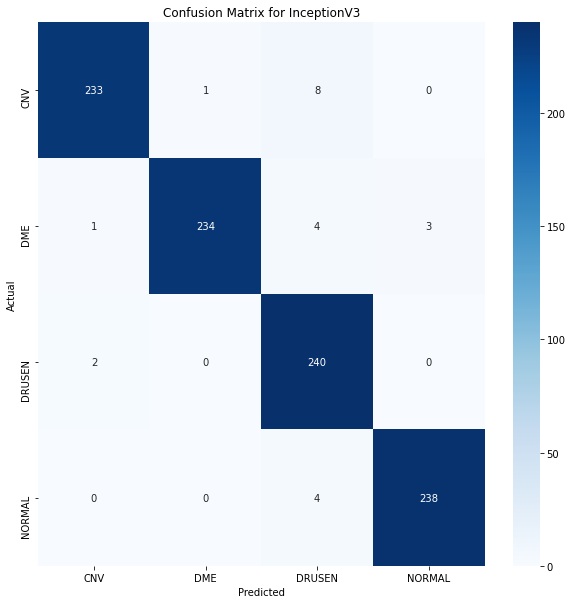

In [81]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

plot_confusion_matrix(all_labels, all_preds, class_names, 'InceptionV3')

In [82]:
# Load predictions and labels
with open('ResNet50_4W/model_predictions_4w.json', 'r') as f:
    data = json.load(f)
    all_labels = np.array(data['labels'])
    all_preds = np.array(data['predictions'])
    metrics_resnet50 = classification_report(all_labels, all_preds, output_dict=True)

resnet50_report = classification_report(all_labels, all_preds)
print(resnet50_report)

              precision    recall  f1-score   support

           0       0.72      0.94      0.82       242
           1       0.90      0.91      0.91       242
           2       0.95      0.64      0.76       242
           3       0.96      0.97      0.96       242

    accuracy                           0.87       968
   macro avg       0.88      0.87      0.86       968
weighted avg       0.88      0.87      0.86       968



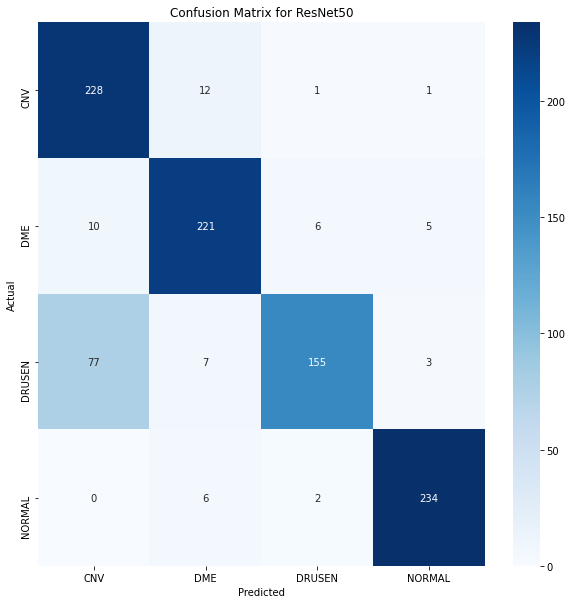

In [83]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

plot_confusion_matrix(all_labels, all_preds, class_names, 'ResNet50')

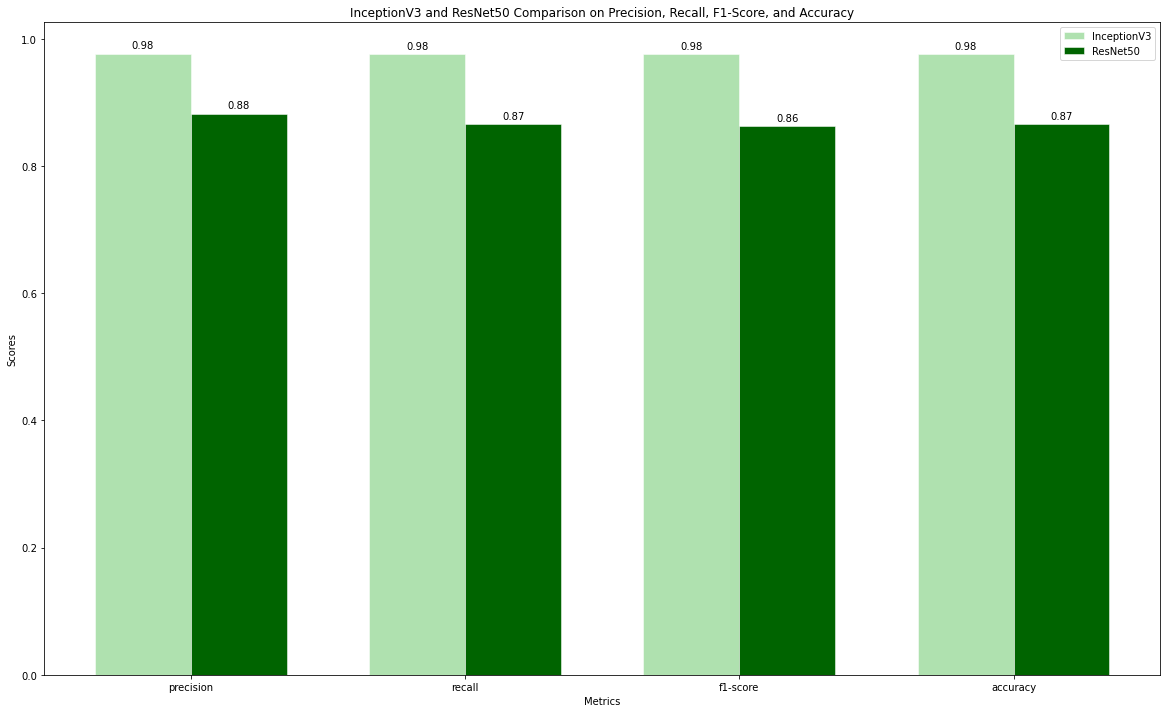

In [84]:
# Metrics to display
metrics = ['precision', 'recall', 'f1-score', 'accuracy']
inceptionv3_scores = [metrics_inceptionv3[metric] if metric == 'accuracy' else metrics_inceptionv3['macro avg'][metric] for metric in metrics]
resnet50_scores = [metrics_resnet50[metric] if metric == 'accuracy' else metrics_resnet50['macro avg'][metric] for metric in metrics]

# X locations for the groups
ind = np.arange(len(metrics))

# Bar plot settings
plt.figure(figsize=(20, 12))
bar_width = 0.35
color_light_green = '#AFE1AF'  # Light green
color_dark_green = '#006400'   # Dark green

# Creating the bar plots
rects1 = plt.bar(ind - bar_width/2, inceptionv3_scores, bar_width, label='InceptionV3', edgecolor='white', linewidth=0.5, color=color_light_green)
rects2 = plt.bar(ind + bar_width/2, resnet50_scores, bar_width, label='ResNet50', edgecolor='white', linewidth=0.5, color=color_dark_green)

# Adding values on the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Setting labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('InceptionV3 and ResNet50 Comparison on Precision, Recall, F1-Score, and Accuracy')
plt.xticks(ind, metrics)
plt.legend()

# Display the plot
plt.show()